# REF: 
<br>https://phamdinhkhanh.github.io/2019/12/12/ARIMAmodel.html
<br>https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

# <span style='color:Green'>Background</span>
In this project, i'll run through an example of coffee price forecasting using **<span style='color:Green'>SARIMA (Seasonal Autoregressive Integrated Moving Average)</span>** model. The data is collected in VietNam from 01-2021 to 04-2023. The model will look back at 60 days in the dataset and predict the next 30 days for the coffee price, then the effectiveness will be meaesured using RMSE / MAPE (mean absolute percentage error). <b>The following topics will be covered:
- <b>Stationarity (Differencing and Augmented Dickey-Fuller Test)
- <b>ACF and PACF Plots
- <b>Grid Search and AIC
- <b>Walk Forward Validation
- <b>MAPE
- <b>Exogenous Variables</b>

# <span style='color:Green'>  Import Libraries </span>

In [1]:
# Data Handling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
import tensorflow as tf
import sklearn

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Feature Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Other Packages
import warnings
warnings.filterwarnings("ignore")

# <span style='color:Green'>  EDA & Visualizing </span>

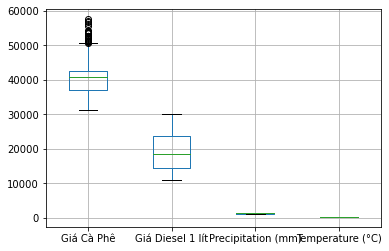

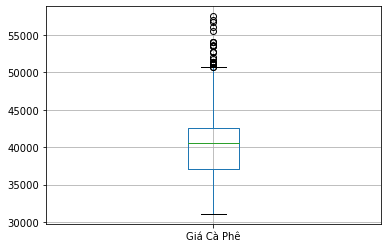

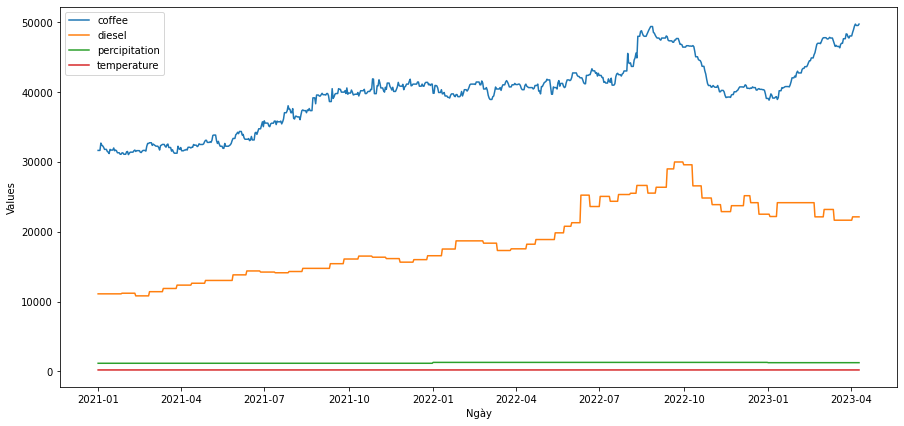

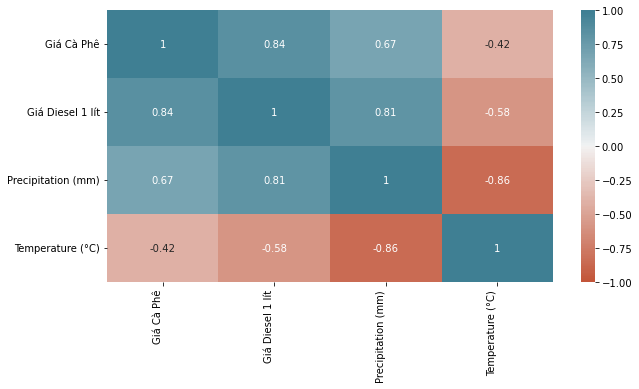

Stored 'data' (DataFrame)
Stored 'look_back' (int)
Stored 'predict_ahead' (int)


In [2]:
%run Data.ipynb

# <span style='color:Green'> ---------- Retrieve Data ----------- </span>

In [3]:
%store -r data
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm),Temperature (°C)
0,2021-01-01,31667.5,11120.0,1174.199994,217.0
1,2021-01-02,31667.5,11120.0,1174.199994,217.0
2,2021-01-03,31667.5,11120.0,1174.199994,217.0
3,2021-01-04,32717.0,11120.0,1174.199994,217.0
4,2021-01-05,32417.0,11120.0,1174.199994,217.0
...,...,...,...,...,...
825,2023-04-06,49766.5,22150.0,1259.800013,218.0
826,2023-04-07,49566.5,22150.0,1259.800013,218.0
827,2023-04-08,49566.5,22150.0,1259.800013,218.0
828,2023-04-09,49566.5,22150.0,1259.800013,218.0


In [4]:
# take coffee price only
data.drop(data.columns[[-1, -2, -3]], axis=1, inplace=True)

In [5]:
data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


In [6]:
# Lưu data gốc dưới tên sau
original_data = data.copy()

#   --------- Normalization ( Xử lý, biến đổi dữ liệu) ---------- 

In [7]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)

In [8]:
# set number of days
look_back = 60
predict_ahead = 30

# frame as supervised learning
reframed = series_to_supervised(data.values, look_back, predict_ahead)

In [9]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column
var_index = (look_back * data_column) + ((predict_ahead - 1) * data_column)

# drop unnecessary columns
reframed = reframed.drop(reframed.iloc[:, keep_column:var_index], axis = 1)
# index_drop = (data_column - 1 ) * -1
# reframed = reframed.drop(columns=reframed.columns[index_drop:], axis = 1)
# dataset = reframed

In [10]:
reframed

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t+29)
60,31667.5,31667.5,31667.5,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,...,31667.0,31567.0,32267.0,32667.0,32667.00,32767.00,32767.00,32767.00,32388.75,31817.0
61,31667.5,31667.5,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,...,31567.0,32267.0,32667.0,32667.0,32767.00,32767.00,32767.00,32388.75,32575.00,32081.5
62,31667.5,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,31417.0,...,32267.0,32667.0,32667.0,32767.0,32767.00,32767.00,32388.75,32575.00,32475.00,31617.0
63,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,31417.0,31217.0,...,32667.0,32667.0,32767.0,32767.0,32767.00,32388.75,32575.00,32475.00,32375.00,31617.0
64,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,31417.0,31217.0,31817.0,...,32667.0,32767.0,32767.0,32767.0,32388.75,32575.00,32475.00,32375.00,32275.00,31617.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,39166.5,39166.5,39316.5,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,...,46966.5,47266.5,47616.5,47800.0,47816.50,47816.50,47816.50,47666.50,47616.50,49766.5
796,39166.5,39316.5,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,40616.5,...,47266.5,47616.5,47800.0,47816.5,47816.50,47816.50,47666.50,47616.50,47716.50,49566.5
797,39316.5,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,40616.5,40666.5,...,47616.5,47800.0,47816.5,47816.5,47816.50,47666.50,47616.50,47716.50,47866.50,49566.5
798,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,40616.5,40666.5,40766.5,...,47800.0,47816.5,47816.5,47816.5,47666.50,47616.50,47716.50,47866.50,47766.50,49566.5


 Bước trên:  'reframed' k liên quan đến phân tích chuỗi thời gian ? <br> _Hay thuộc cách thức tạo chuỗi thời gian, nếu đúng vậy thì bước tiếp theo là..

# ---- Phân tích chuỗi thời gian ----

Ta áp dụng Sai phân (differencing) để biến đổi chuỗi thời gian ban đầu thành chuỗi dừng (stationary series).
<br>-> Chuỗi dừng có thể giúp trong việc loại bỏ yếu tố mùa vụ và làm cho dữ liệu ổn định hơn để áp dụng mô hình SARIMA hoặc ARIMA.
### Trong trường hợp 1, ta sẽ biến đổi 'reframed' thành chuỗi dừng và xây dựng model ARIMA (loại bỏ yếu tố mùa vụ)

Ta sẽ chuyển chuỗi giá sang chuỗi dừng bằng cách lấy lợi suất theo công thức sai phân bậc 1 của logarit, hoặc sai phân bậc 1 thông thường

In [11]:
reframed_diff = reframed.diff().dropna()

In [12]:
reframed_diff

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t+29)
61,0.0,0.0,1049.5,-300.0,-100.0,-200.0,-300.0,0.0,0.0,-300.0,...,-100.0,700.0,400.0,0.00,100.00,0.00,0.00,-378.25,186.25,264.5
62,0.0,1049.5,-300.0,-100.0,-200.0,-300.0,0.0,0.0,-300.0,-100.0,...,700.0,400.0,0.0,100.00,0.00,0.00,-378.25,186.25,-100.00,-464.5
63,1049.5,-300.0,-100.0,-200.0,-300.0,0.0,0.0,-300.0,-100.0,-200.0,...,400.0,0.0,100.0,0.00,0.00,-378.25,186.25,-100.00,-100.00,0.0
64,-300.0,-100.0,-200.0,-300.0,0.0,0.0,-300.0,-100.0,-200.0,600.0,...,0.0,100.0,0.0,0.00,-378.25,186.25,-100.00,-100.00,-100.00,0.0
65,-100.0,-200.0,-300.0,0.0,0.0,-300.0,-100.0,-200.0,600.0,-100.0,...,100.0,0.0,0.0,-378.25,186.25,-100.00,-100.00,-100.00,0.00,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,150.0,50.0,-400.0,250.0,1000.0,0.0,0.0,450.0,...,-50.0,300.0,350.0,183.50,16.50,0.00,0.00,-150.00,-50.00,300.0
796,0.0,150.0,50.0,-400.0,250.0,1000.0,0.0,0.0,450.0,-50.0,...,300.0,350.0,183.5,16.50,0.00,0.00,-150.00,-50.00,100.00,-200.0
797,150.0,50.0,-400.0,250.0,1000.0,0.0,0.0,450.0,-50.0,50.0,...,350.0,183.5,16.5,0.00,0.00,-150.00,-50.00,100.00,150.00,0.0
798,50.0,-400.0,250.0,1000.0,0.0,0.0,450.0,-50.0,50.0,100.0,...,183.5,16.5,0.0,0.00,-150.00,-50.00,100.00,150.00,-100.00,0.0


<u>Nhận xét: 
+ Một số giá trị bằng 0 tại vì có các giá trị giống nhau liên tiếp
+ Các giá trị đầu tiên sau khi áp dụng sai phân sẽ trở thành NaN. Điều này xảy ra vì không có giá trị trước đó để lấy hiệu (difference) với giá trị đầu tiên. (nhưng ta đã loại bỏ NaN trong bảng)

### Kiểm tra tính dừng

In [13]:
from statsmodels.tsa.stattools import adfuller

# Áp dụng ADF test cho mỗi cột của reframed_diff
adf_results_diff = []

for col in reframed_diff.columns:
    result_diff = adfuller(reframed_diff[col].dropna())  # Loại bỏ NaN values nếu có
    adf_results_diff.append((col, result_diff[0], result_diff[1]))

# In kết quả ADF cho từng cột sau khi sai phân
for col, statistic_diff, p_value_diff in adf_results_diff:
    print(f'ADF Statistic for {col} after differencing: {statistic_diff}')
    print(f'p-value for {col} after differencing: {p_value_diff}')
    if p_value_diff <= 0.05:
        print(f'Time series {col} is STATIONARY after differencing')
    else:
        print(f'Time series {col} is NOT STATIONARY after differencing')
    print()

ADF Statistic for var1(t-60) after differencing: -21.06319546688202
p-value for var1(t-60) after differencing: 0.0
Time series var1(t-60) is STATIONARY after differencing

ADF Statistic for var1(t-59) after differencing: -21.17924552265963
p-value for var1(t-59) after differencing: 0.0
Time series var1(t-59) is STATIONARY after differencing

ADF Statistic for var1(t-58) after differencing: -21.026402205156533
p-value for var1(t-58) after differencing: 0.0
Time series var1(t-58) is STATIONARY after differencing

ADF Statistic for var1(t-57) after differencing: -21.045995721969994
p-value for var1(t-57) after differencing: 0.0
Time series var1(t-57) is STATIONARY after differencing

ADF Statistic for var1(t-56) after differencing: -21.10211848452542
p-value for var1(t-56) after differencing: 0.0
Time series var1(t-56) is STATIONARY after differencing

ADF Statistic for var1(t-55) after differencing: -21.110582134356463
p-value for var1(t-55) after differencing: 0.0
Time series var1(t-55)

In [14]:
# from statsmodels.tsa.stattools import adfuller
# result = adfuller(reframed_diff)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))
    
#0th element test statistic: -27
    # more negative means more likely to be stationary
    
#1st element is test p-value: 0.
    # if p-value is < 0.05 -> reject null hypothesis -> reject non-stationary -> must be stationary
    
#4th element is the critical test statistics (dictionary) equate to different p-values
    # if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.86

## Trường hợp 2: Kiểm tra yếu tố mùa vụ -> Xem có nên dùng SARIMA làm model hay chỉ cần là ARIMA

In [15]:
original_data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


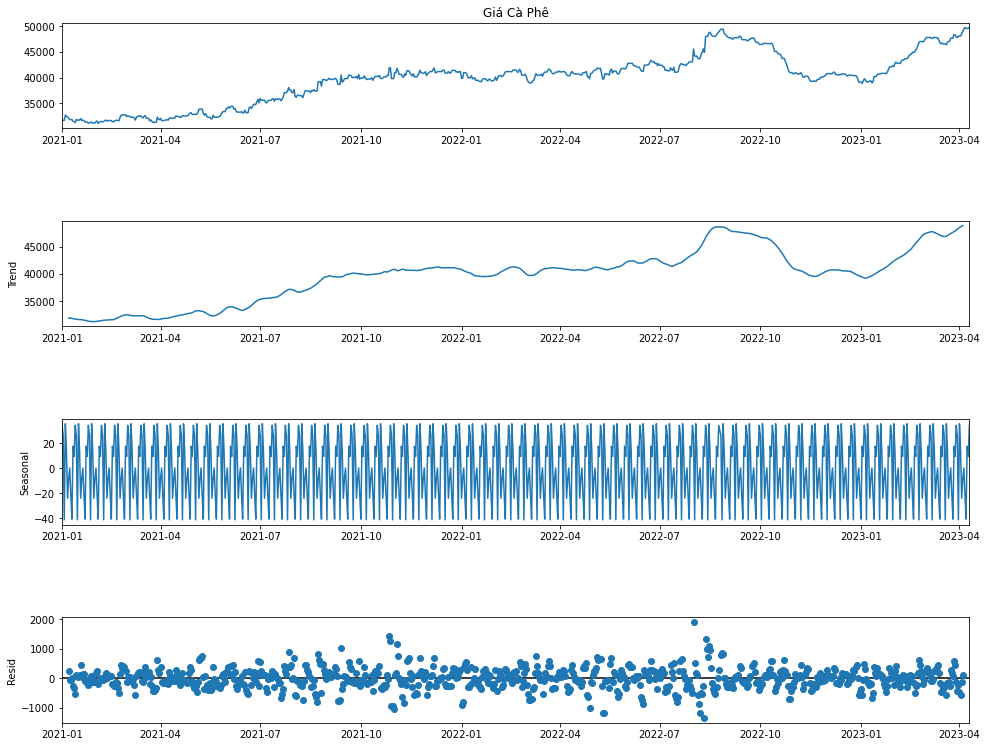

In [16]:
# dùng seasonal_decompose để phân tích các thành phần (observed, trend, seasonal, residual) 
result = seasonal_decompose(original_data['Giá Cà Phê'], period=12) 
result.observed.index = original_data['Ngày']
result.trend.index = original_data['Ngày']
result.seasonal.index = original_data['Ngày']
result.resid.index = original_data['Ngày']

fig = result.plot()
fig.set_size_inches(16, 12)
plt.show()

## Sai phân theo mùa vụ (Seasonal Difference):

In [38]:
s = 7  # 7 ngày
reframed_seasonal_diff = reframed.diff(7).dropna()

In [39]:
reframed_seasonal_diff

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t+29)
67,149.5,149.5,149.5,-1200.0,-1000.0,-1100.0,-300.0,-100.0,-100.0,-100.0,...,1100.00,821.75,308.0,-192.0,-292.00,-492.00,-492.00,-492.00,-313.75,0.0
68,149.5,149.5,-1200.0,-1000.0,-1100.0,-300.0,-100.0,-100.0,-100.0,500.0,...,821.75,308.00,-192.0,-292.0,-492.00,-492.00,-492.00,-313.75,-850.00,-364.5
69,149.5,-1200.0,-1000.0,-1100.0,-300.0,-100.0,-100.0,-100.0,500.0,200.0,...,308.00,-192.00,-292.0,-492.0,-492.00,-492.00,-313.75,-850.00,-125.00,500.0
70,-1200.0,-1000.0,-1100.0,-300.0,-100.0,-100.0,-100.0,500.0,200.0,500.0,...,-192.00,-292.00,-492.0,-492.0,-492.00,-313.75,-850.00,-125.00,50.00,500.0
71,-1000.0,-1100.0,-300.0,-100.0,-100.0,-100.0,500.0,200.0,500.0,-200.0,...,-292.00,-492.00,-492.0,-492.0,-313.75,-850.00,-125.00,50.00,250.00,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,50.0,50.0,450.0,100.0,-800.0,-350.0,1050.0,1050.0,1050.0,1350.0,...,1600.00,1600.00,1350.0,933.5,800.00,800.00,800.00,700.00,350.00,2000.0
796,50.0,450.0,100.0,-800.0,-350.0,1050.0,1050.0,1050.0,1350.0,1250.0,...,1600.00,1350.00,933.5,800.0,800.00,800.00,700.00,350.00,100.00,1500.0
797,450.0,100.0,-800.0,-350.0,1050.0,1050.0,1050.0,1350.0,1250.0,1700.0,...,1350.00,933.50,800.0,800.0,800.00,700.00,350.00,100.00,66.50,1500.0
798,100.0,-800.0,-350.0,1050.0,1050.0,1050.0,1350.0,1250.0,1700.0,1550.0,...,933.50,800.00,800.0,800.0,700.00,350.00,100.00,66.50,-50.00,1500.0


<u>Nhận xét: 
+ lag 7 (s = 7), có thể xuất hiện các giá trị âm trong dữ liệu sai phân mới (reframed_seasonal_diff). Điều này xảy ra khi giá trị hiện tại được trừ đi giá trị của chu kỳ mùa vụ tương ứng cách đó 7 bước thời gian. Khi chu kỳ mùa vụ ảnh hưởng tiêu cực lên giá trị hiện tại, sai phân sẽ tạo ra các giá trị âm.

In [19]:
# Type "nbsp" to add a single space.
# Type "ensp" to add 2 spaces.
# Type "emsp" to add 4 spaces.
# Use the non-breaking space (nbsp) 4 times to insert a tab.
# eg. &emsp;This is an example.

# ---------- Split data  ----------
### For ARIMA

In [20]:
# ARIMA model dataframe: reframed_diff

from sklearn.model_selection import train_test_split

# Specify the features & target
X = reframed_diff.drop(columns=['var1(t+29)'])  # Features
y = reframed_diff['var1(t+29)']  # Target

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (591, 60) (591,)
Testing set shape: (148, 60) (148,)


### For SARIMA

In [65]:
# SARIMA model dataframe: reframed_seasonal_diff

# Specify the features & target
X_seasonal = reframed_diff.drop(columns=['var1(t+29)'])  # Features
y_seasonal = reframed_diff['var1(t+29)']  # Target

# Split the dataset into 80% training and 20% testing
X_seasonal_train, X_seasonal_test, y_seasonal_train, y_seasonal_test = train_test_split(X_seasonal, y_seasonal, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print("Training set shape:", X_seasonal_train.shape, y_seasonal_train.shape)
print("Testing set shape:", X_seasonal_test.shape, y_seasonal_test.shape)


Training set shape: (591, 60) (591,)
Testing set shape: (148, 60) (148,)


In [66]:
# # SARIMA model dataframe: reframed_seasonal_diff

# # Specify the features & target
# X_seasonal = reframed.drop(columns=['var1(t+29)'])  # Features
# y_seasonal = reframed['var1(t+29)']  # Target

# # Split the dataset into 80% training and 20% testing
# X_seasonal_train, X_seasonal_test, y_seasonal_train, y_seasonal_test = train_test_split(X_seasonal, y_seasonal, test_size=0.2, random_state=42)

# # Print the shapes to verify the split
# print("Training set shape:", X_seasonal_train.shape, y_seasonal_train.shape)
# print("Testing set shape:", X_seasonal_test.shape, y_seasonal_test.shape)


# ---------- Xây dựng model và dự đoán -----------

## 1. Xây dựng model ARIMA 
### &nbsp; 1.a Lựa chọn tham số ARIMA(p, d, q)
####  &ensp; 1.a.1. ACF và PACF


- <b>Tự tương quan (ACF - AutoCorrelation Function):</b> là  khái niệm quan trọng trong chuỗi thời gian. Hầu hết các chuỗi thời gian sẽ có sự tương quan với <b>giá trị trễ của nó</b> và <b>các giá trị càng gần nhau</b> thì tương quan càng mạnh hoặc các giá trị cùng thuộc 1 chu kì của chuỗi thì sẽ có tương quan cao (chẳng hạn như cùng tháng trong chu kì năm hay cùng quí trong chu kì năm). <br>
<br>
- <b> Tự tương quan riêng phần (PACF - Partitial AutoCorrelation Function):</b> Về cơ bản tương quan riêng phần cũng là chỉ số đo lường hệ số tương quan như ACF. Tuy nhiên vẫn có sự khác biệt đó là hệ số tương quan này loại bỏ ảnh hưởng của các chuỗi độ trễ trung gian

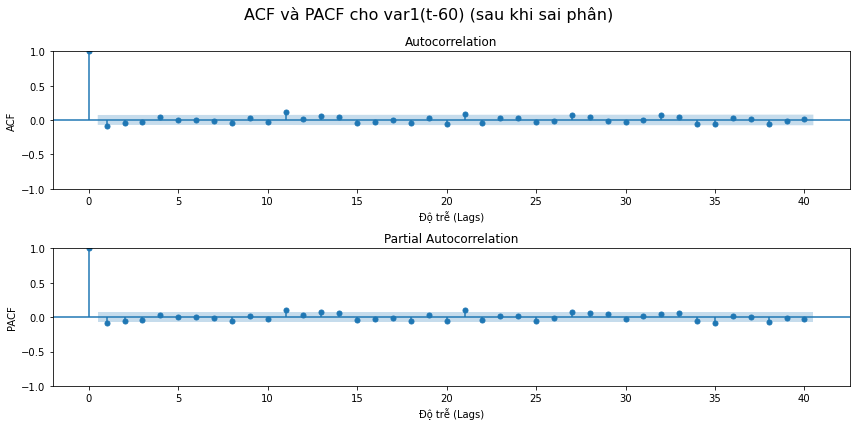

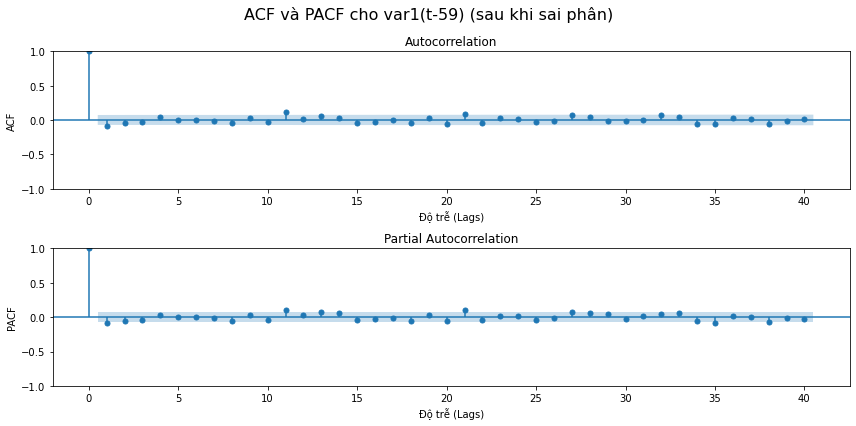

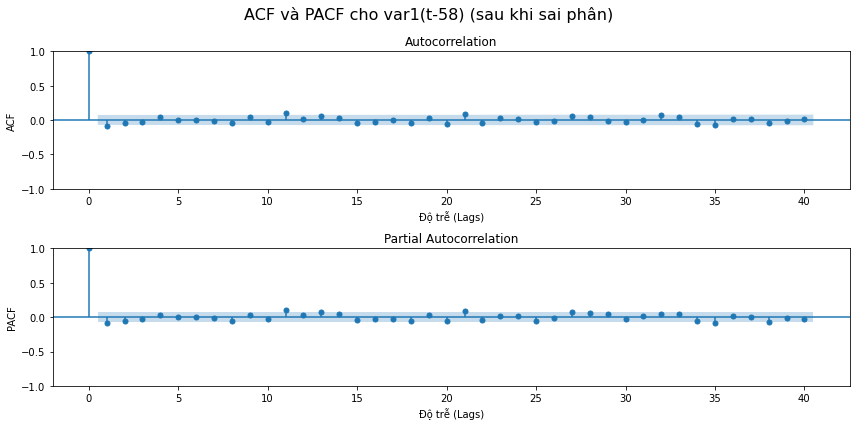

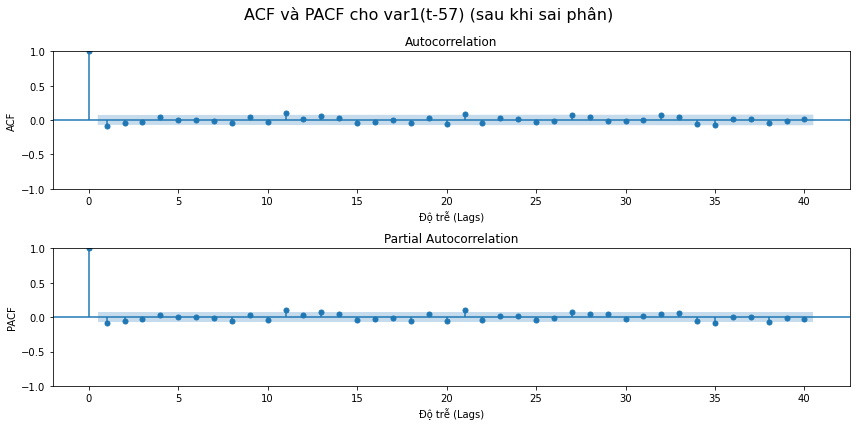

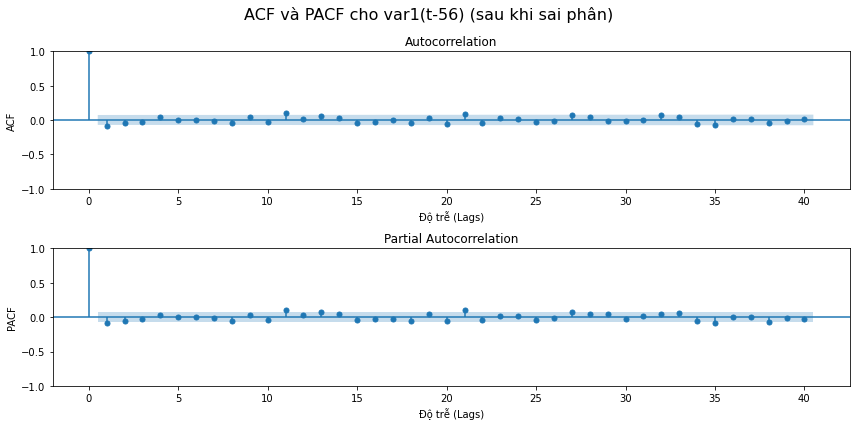

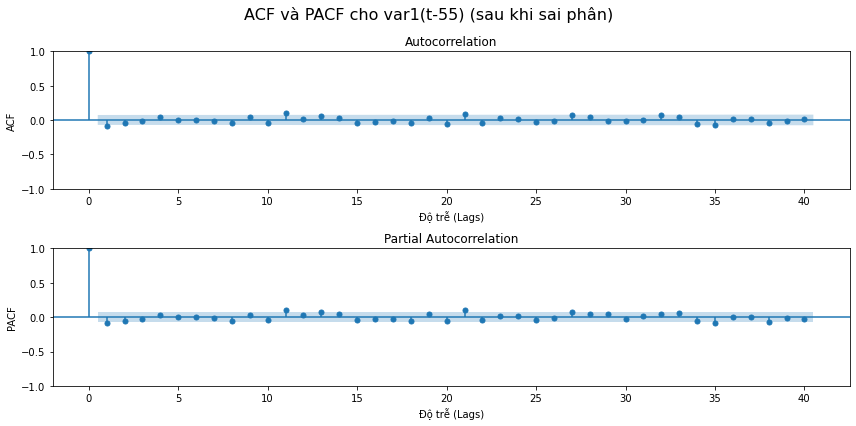

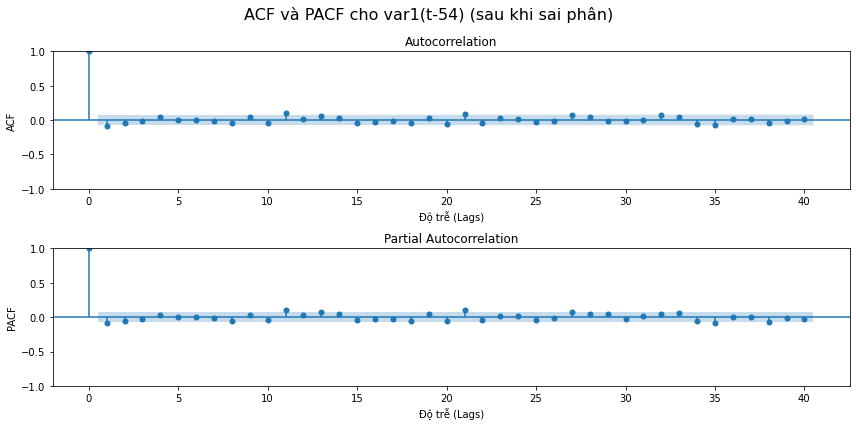

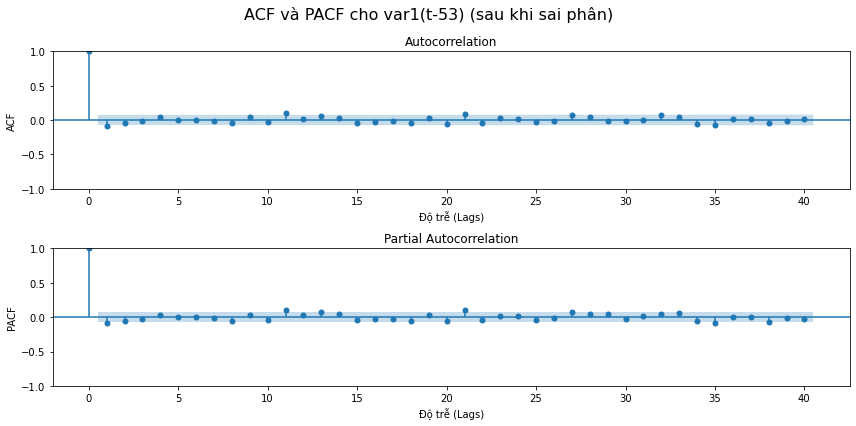

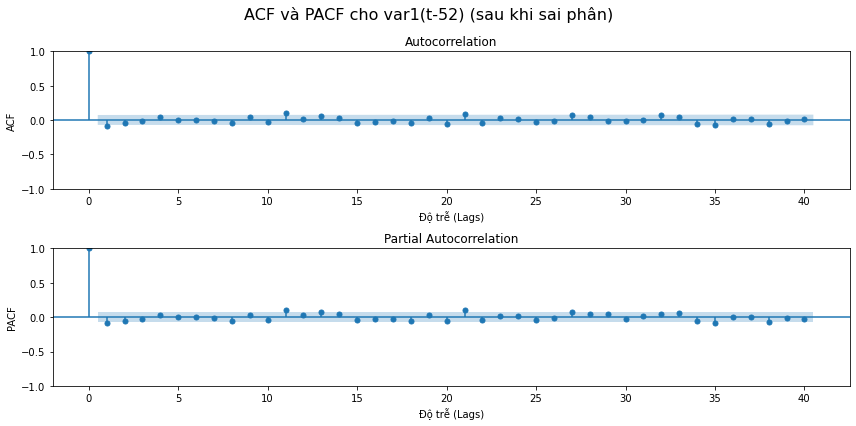

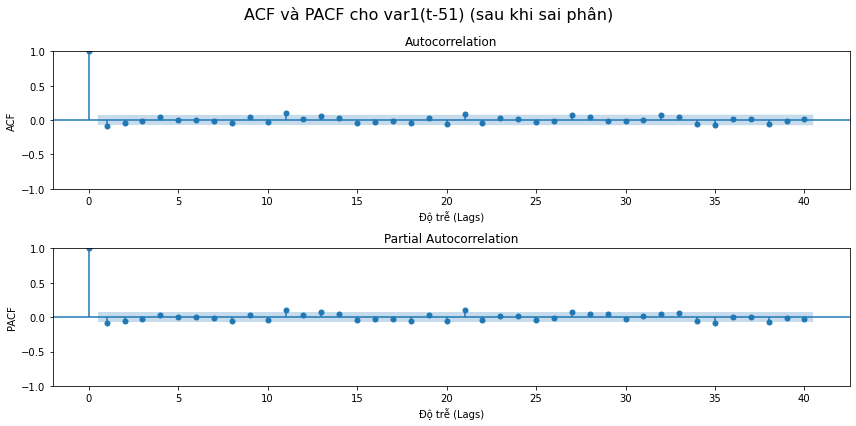

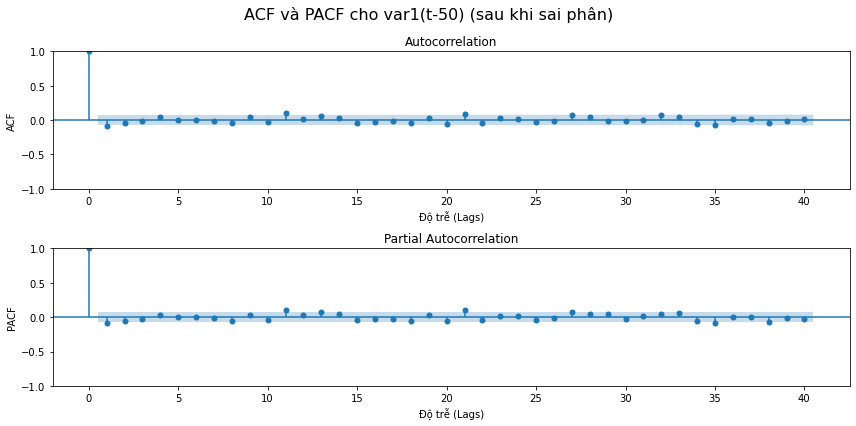

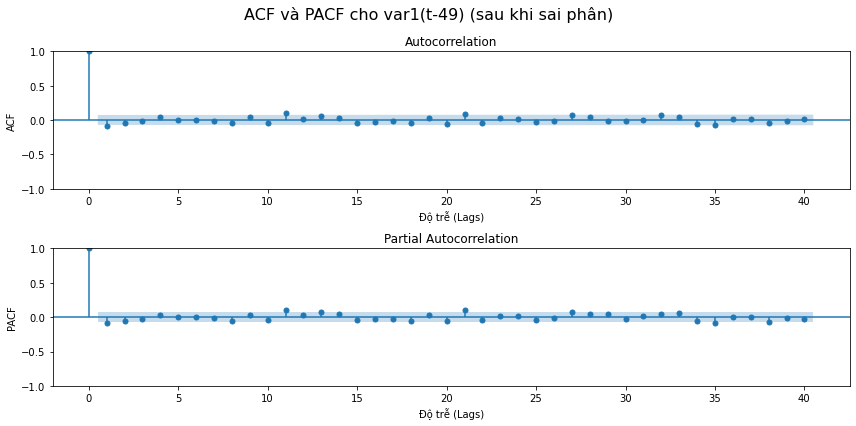

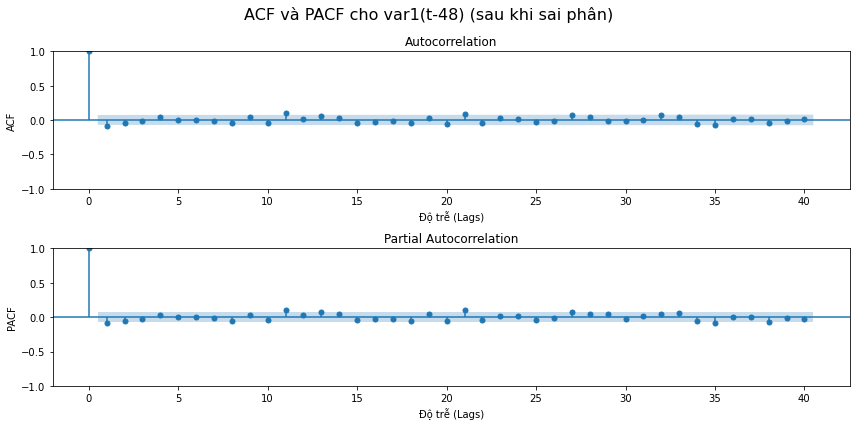

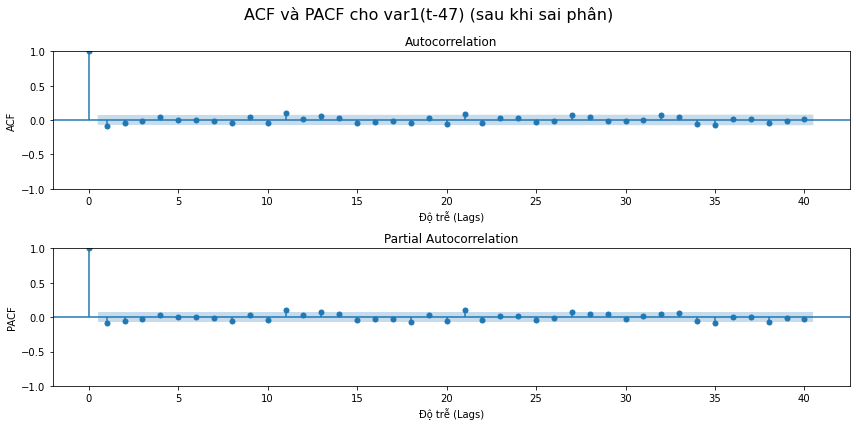

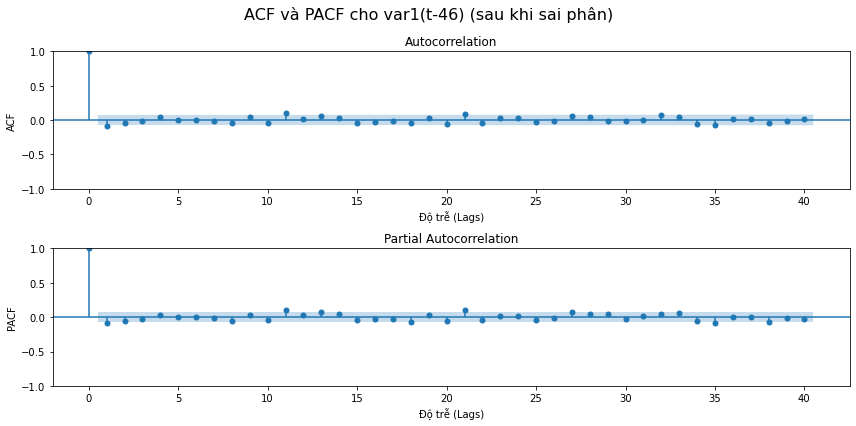

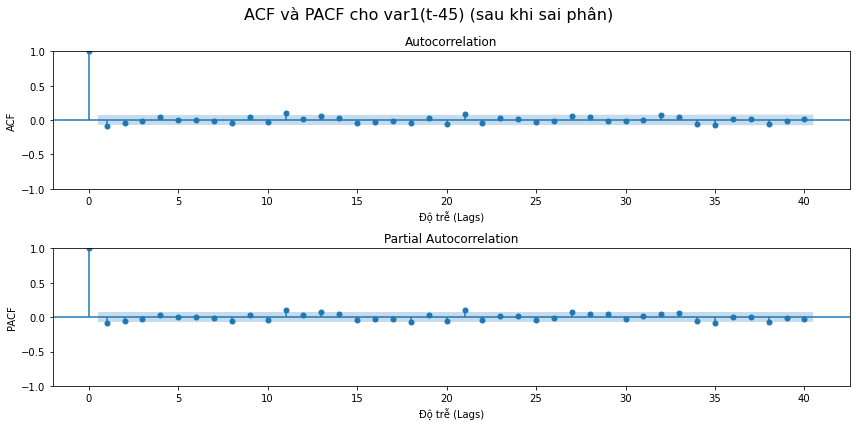

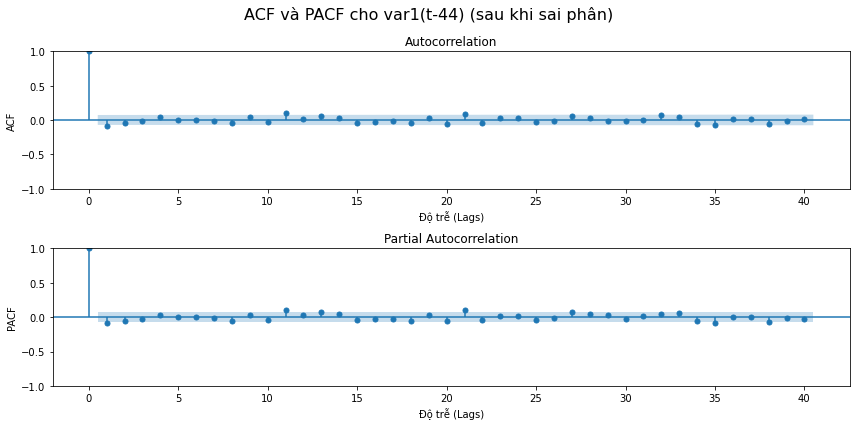

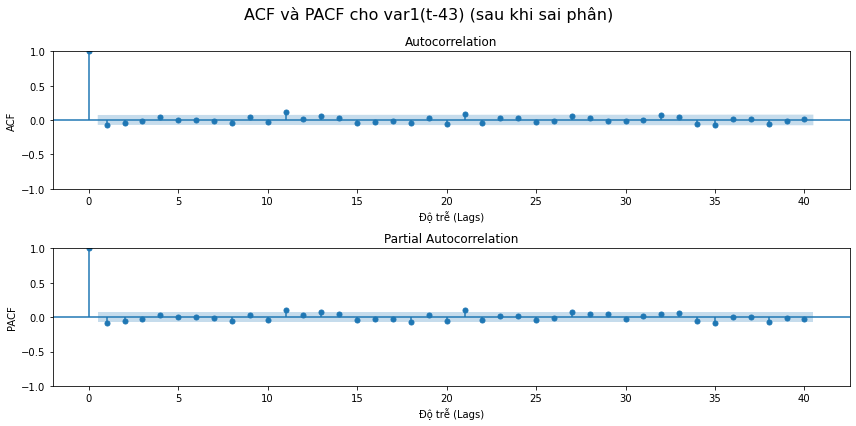

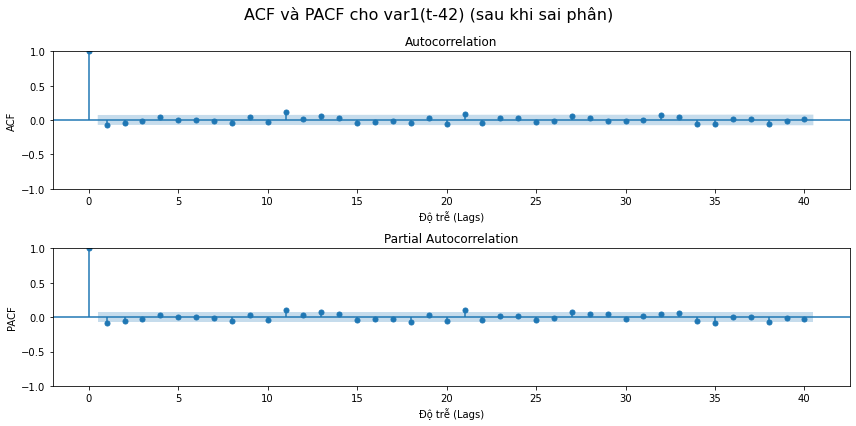

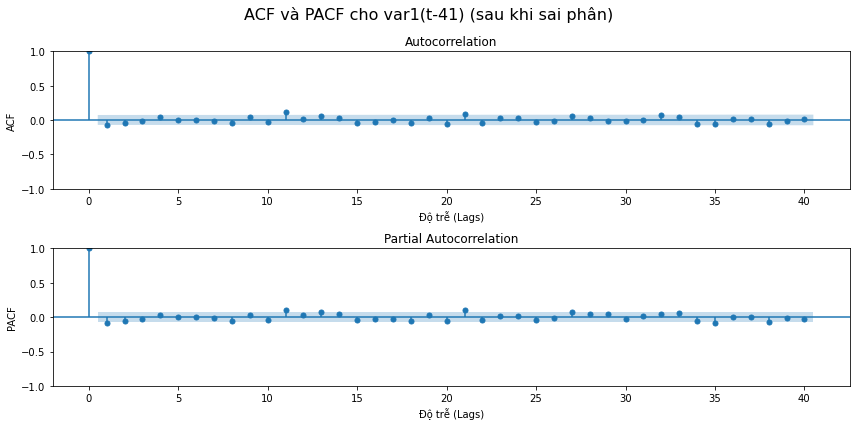

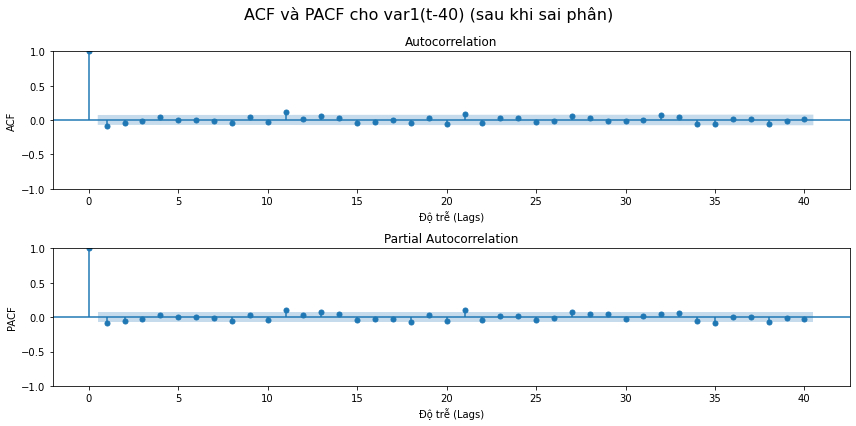

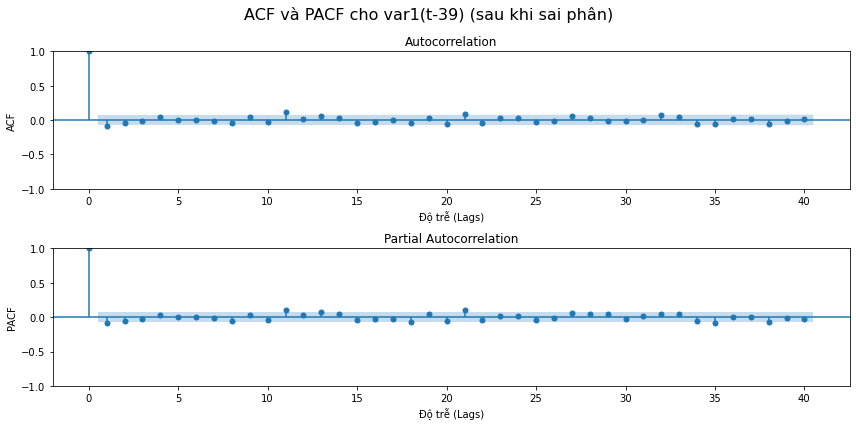

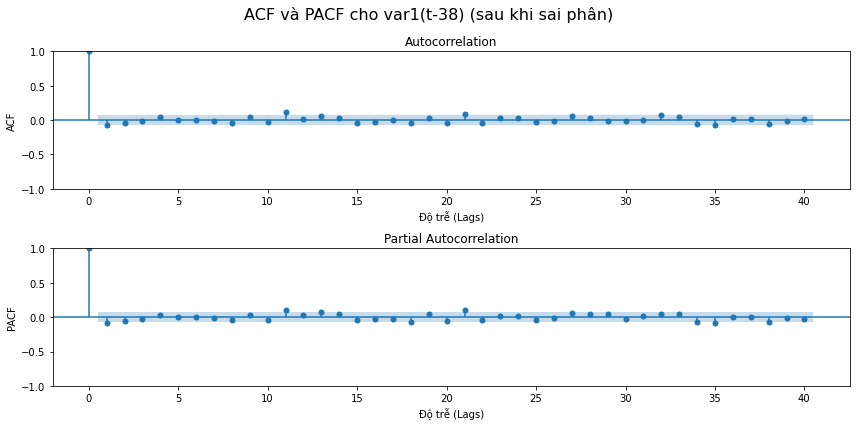

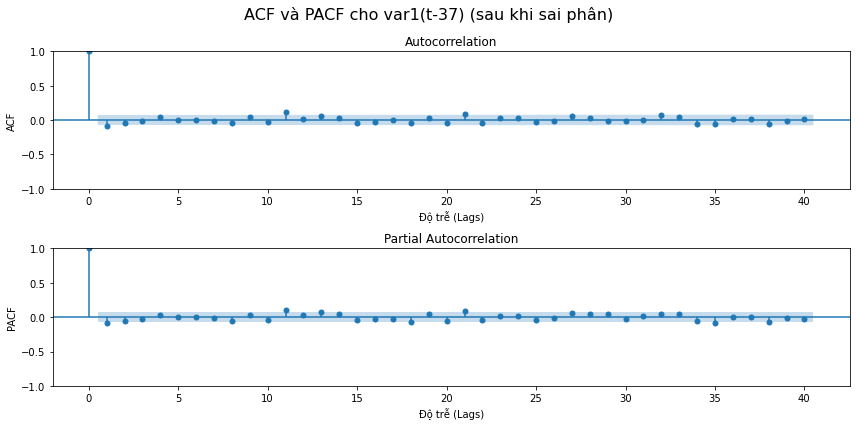

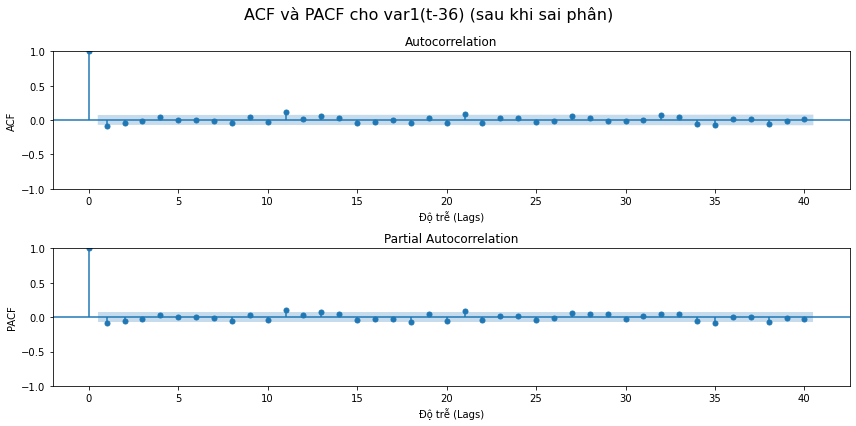

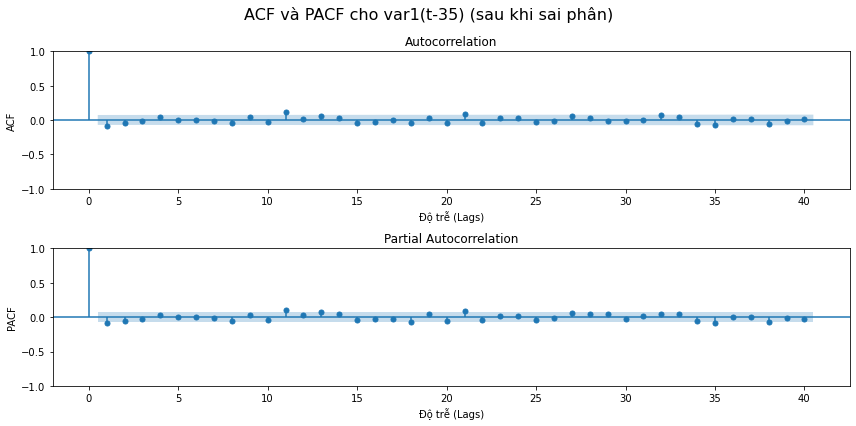

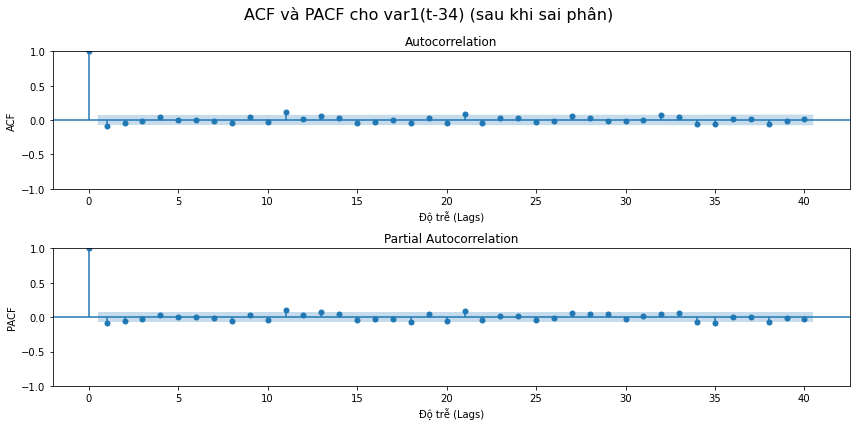

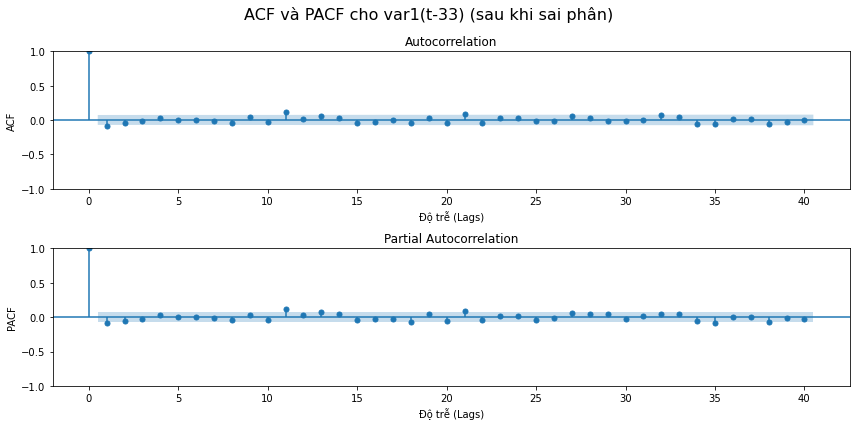

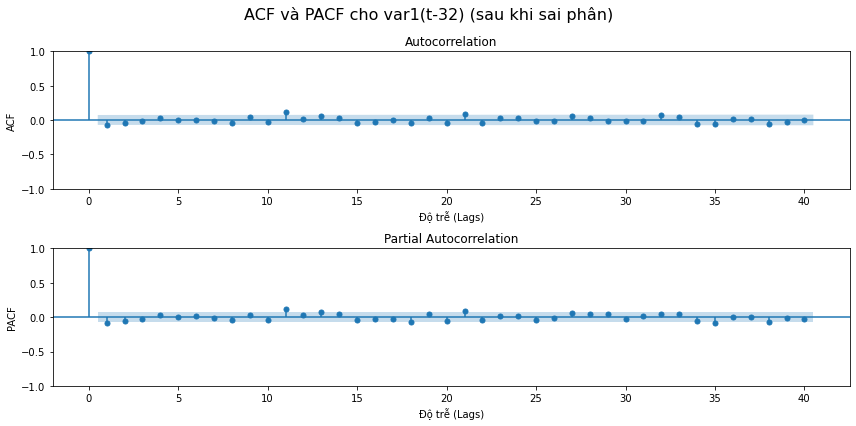

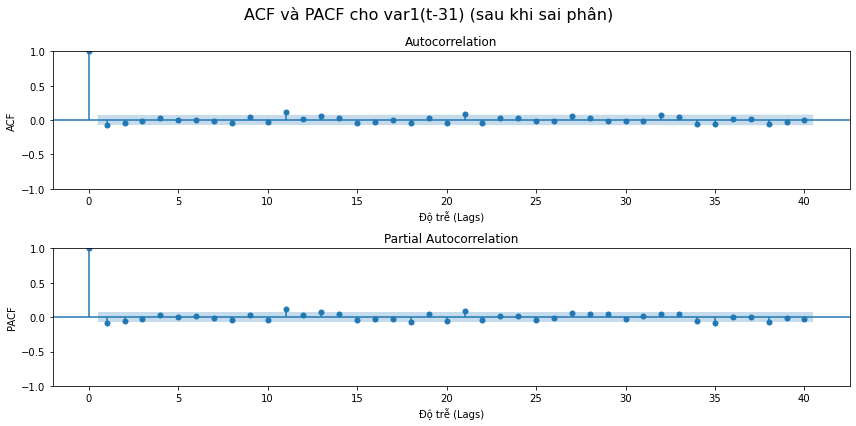

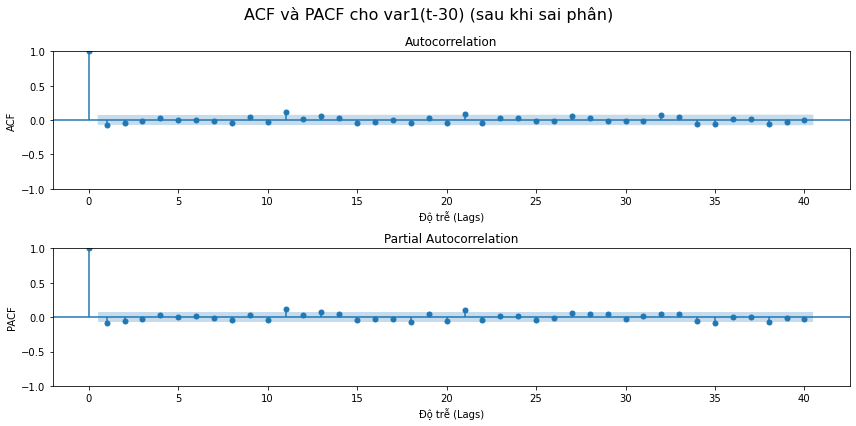

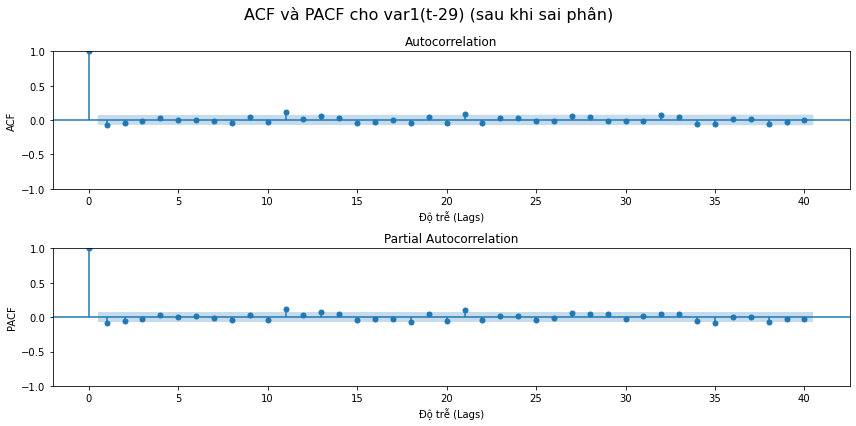

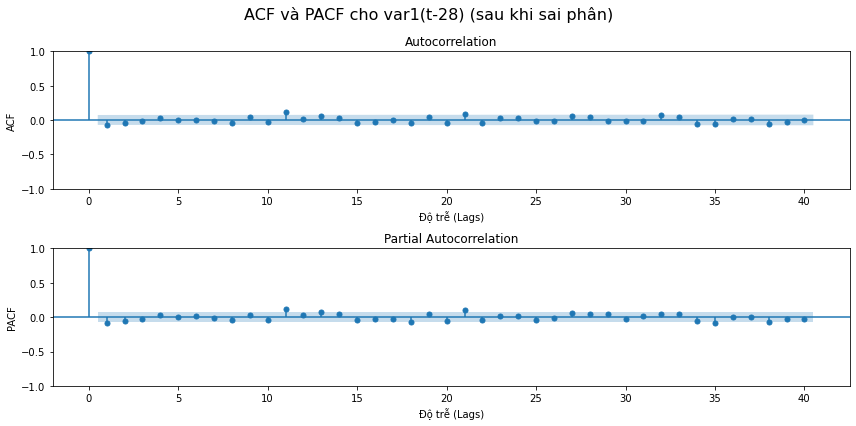

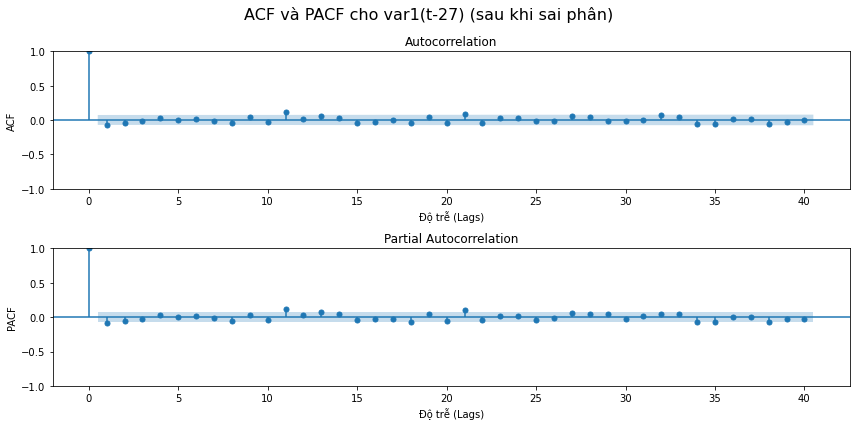

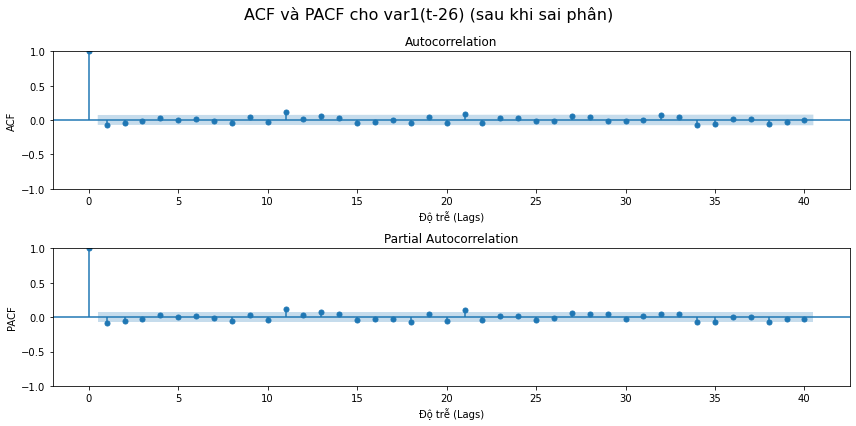

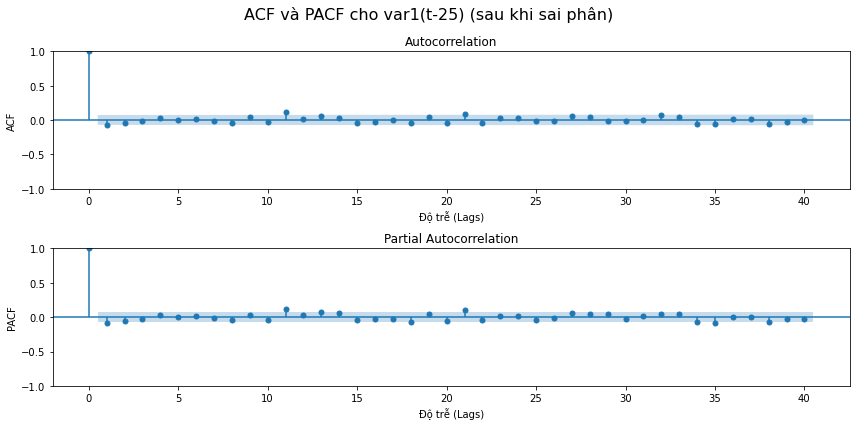

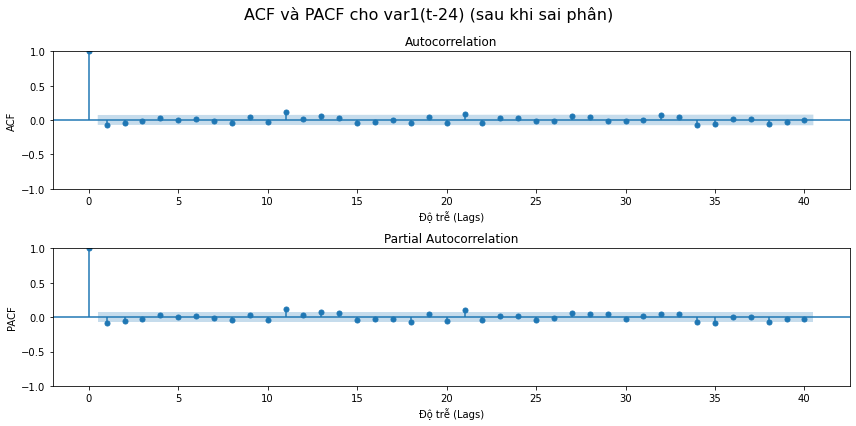

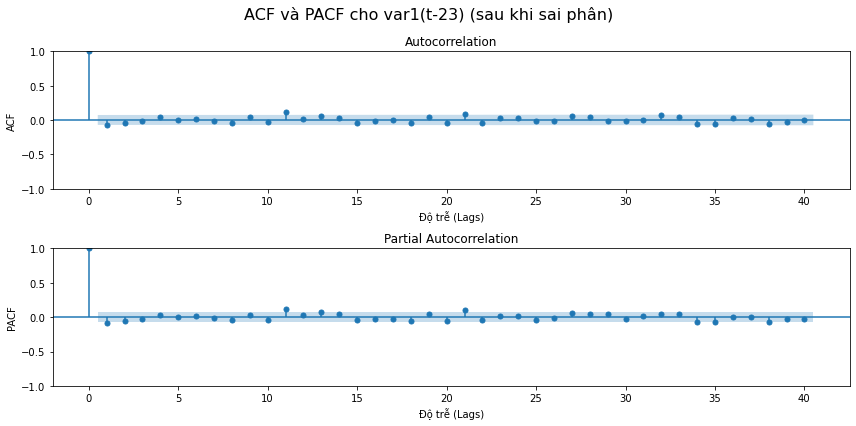

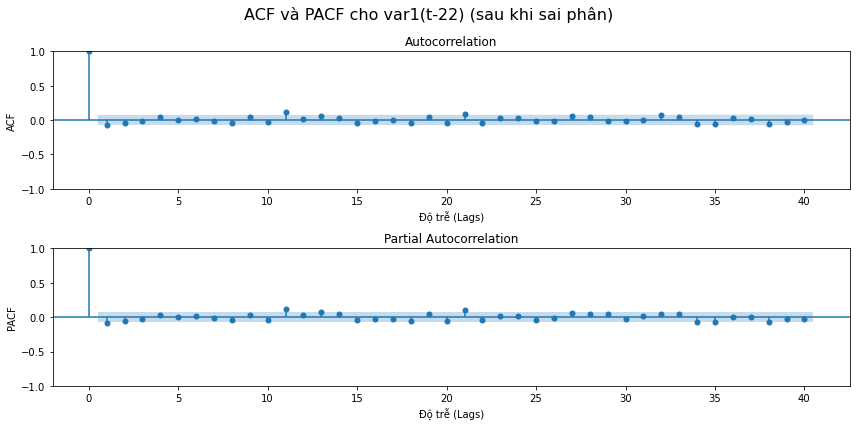

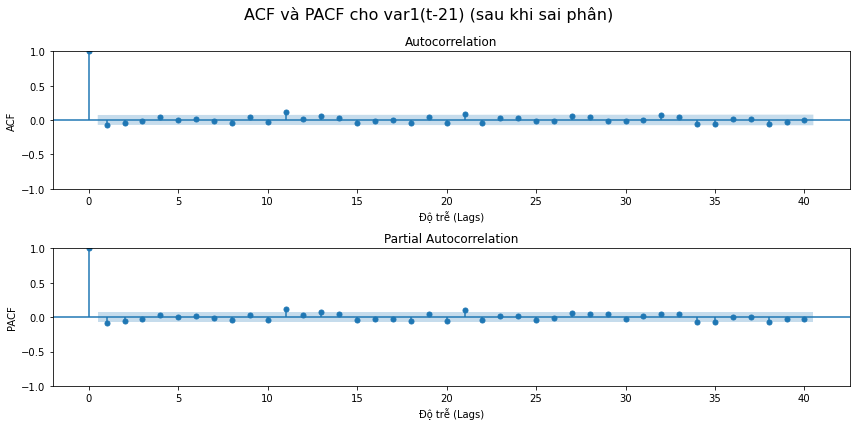

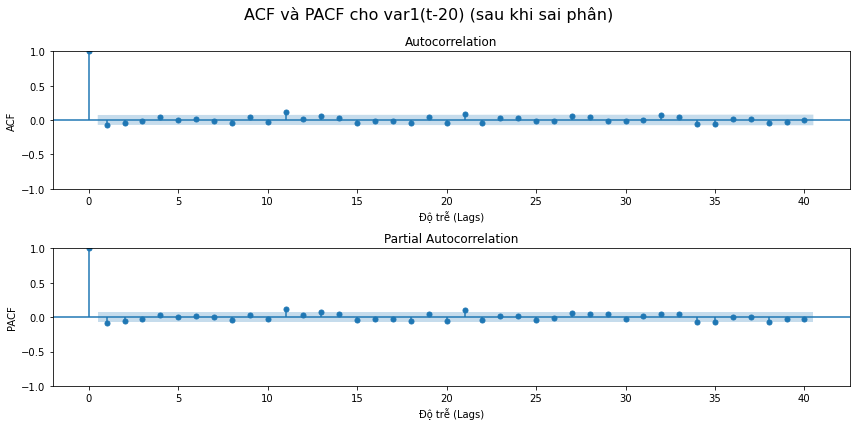

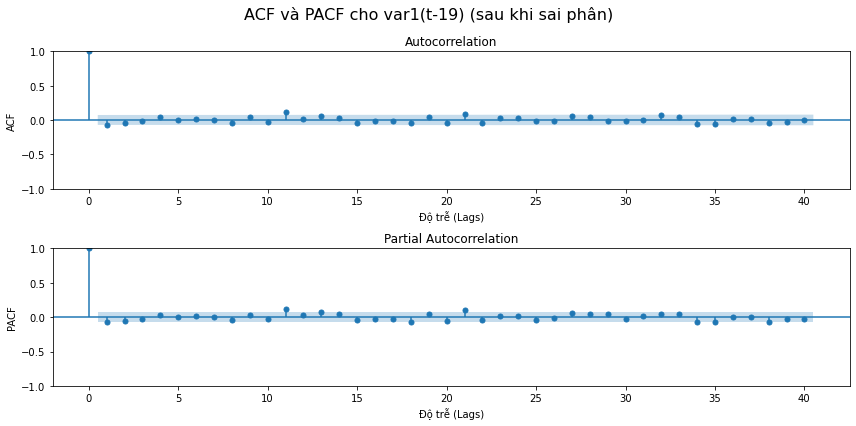

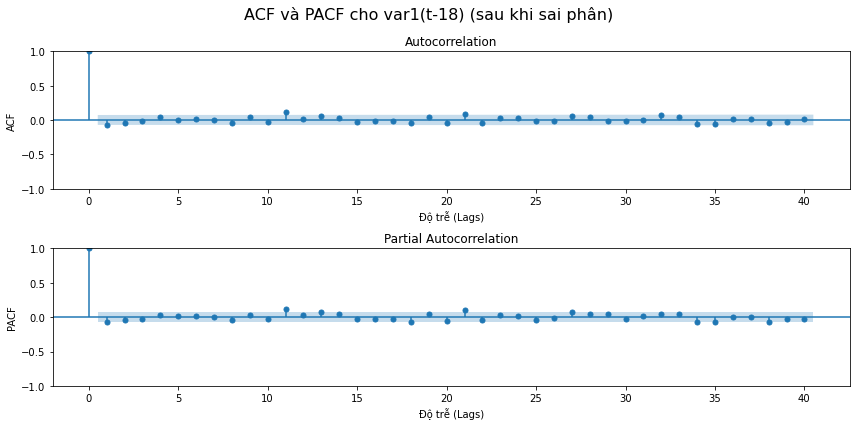

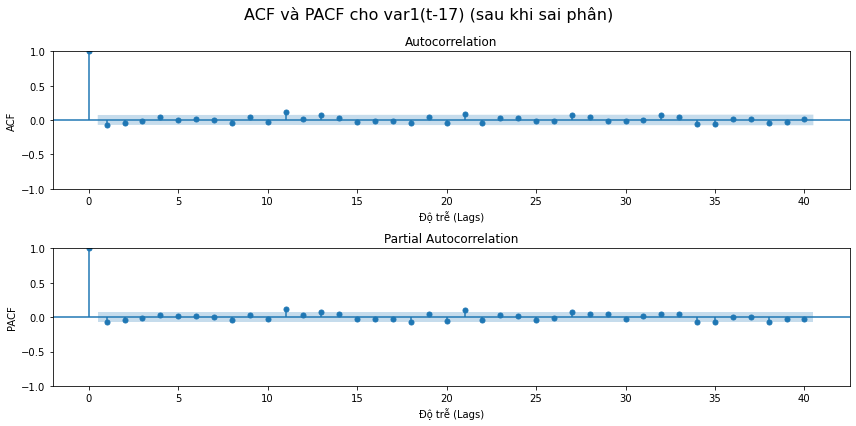

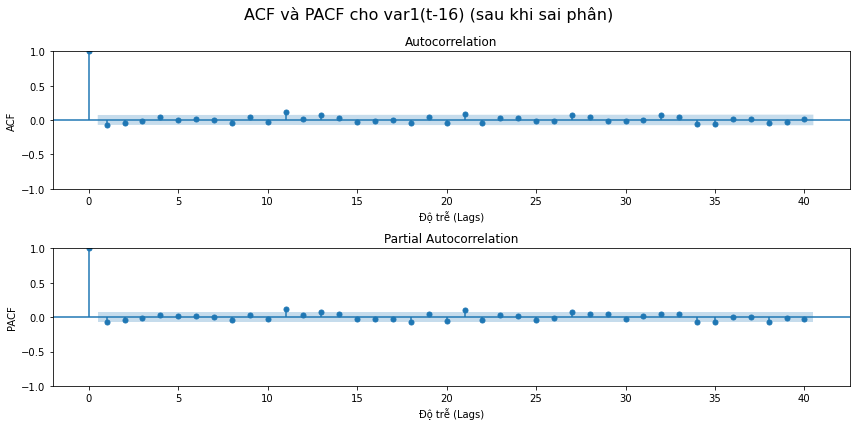

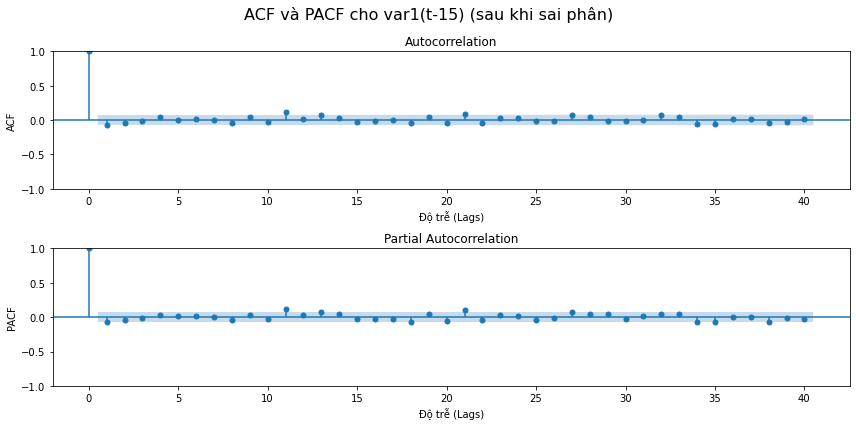

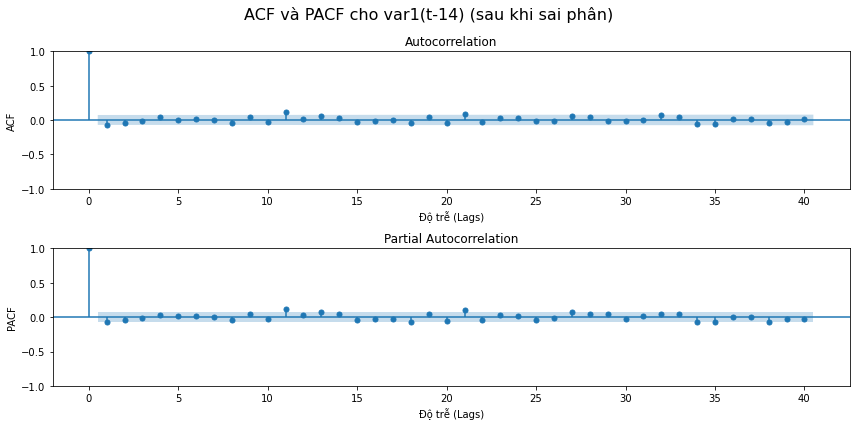

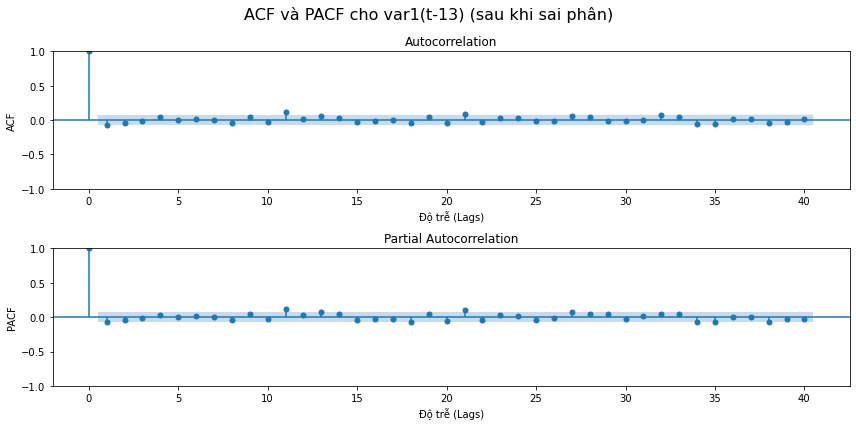

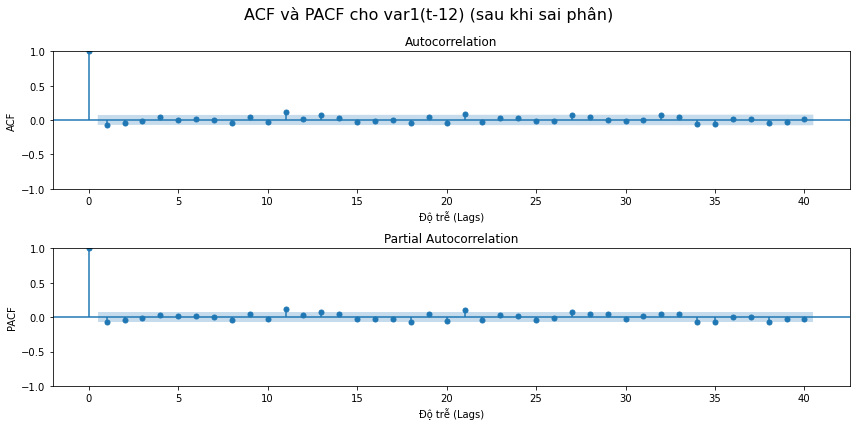

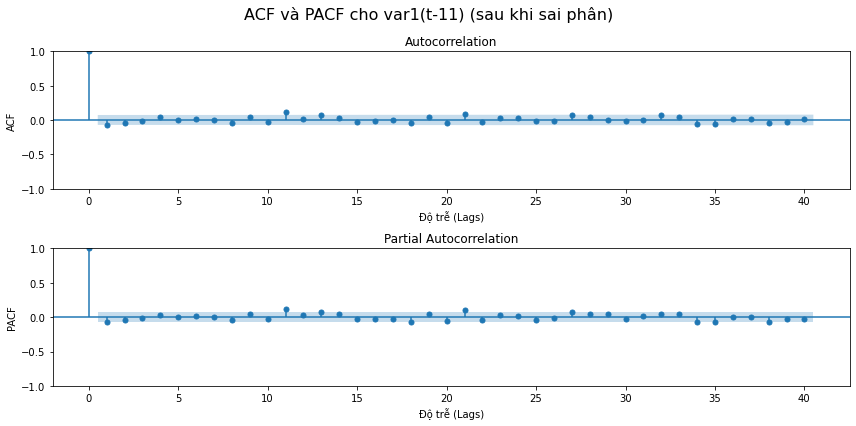

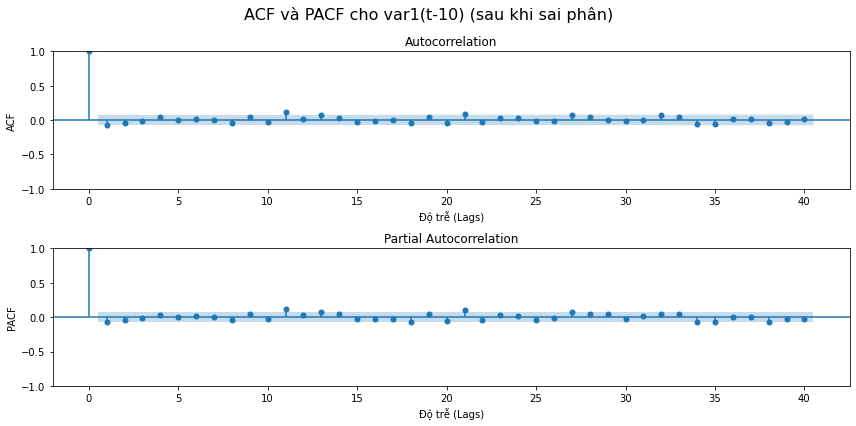

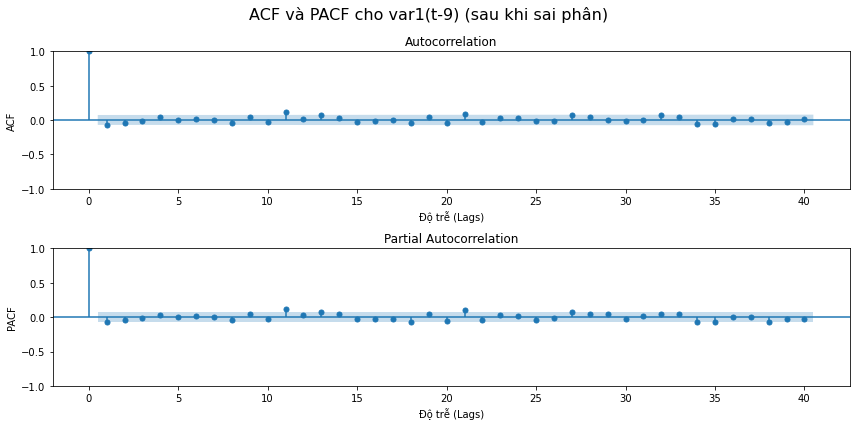

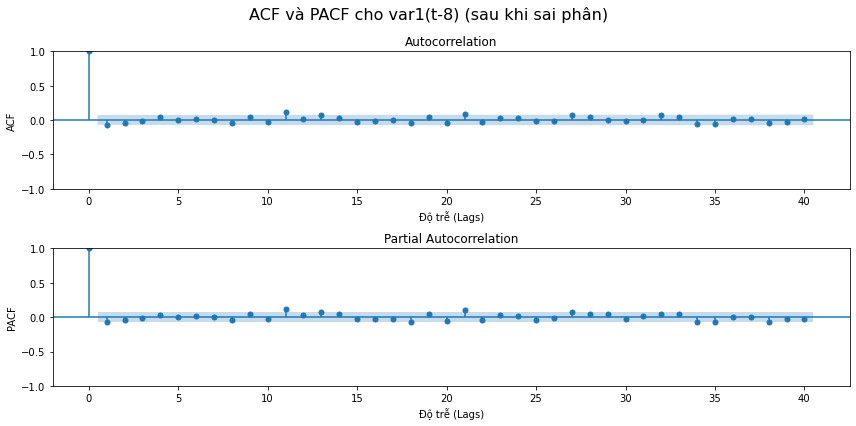

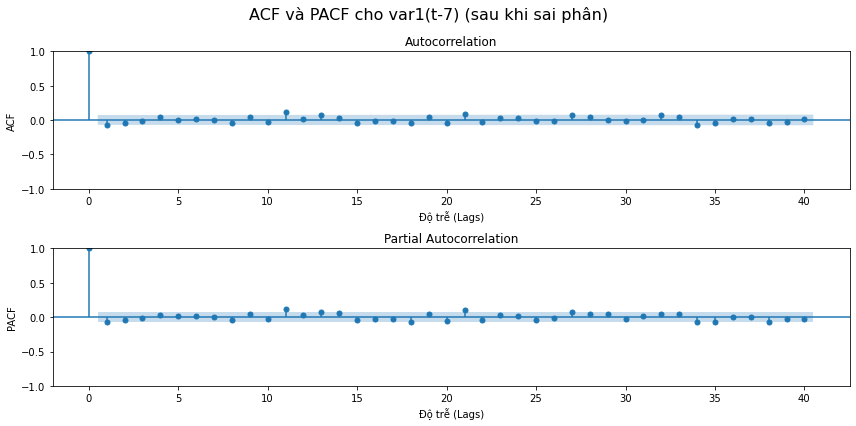

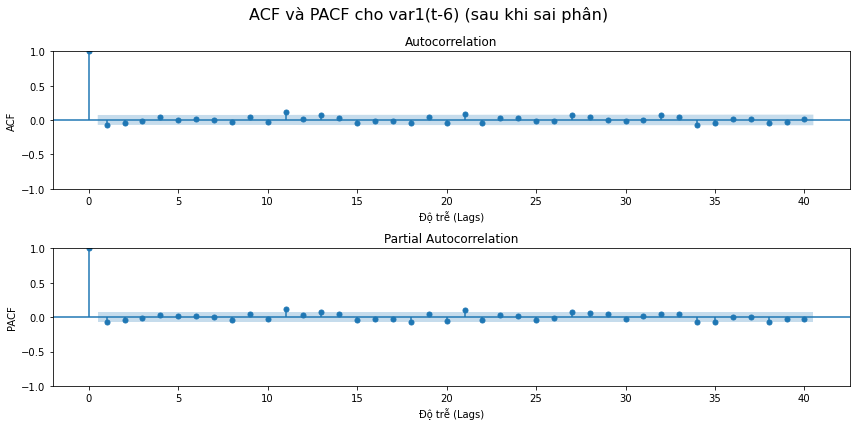

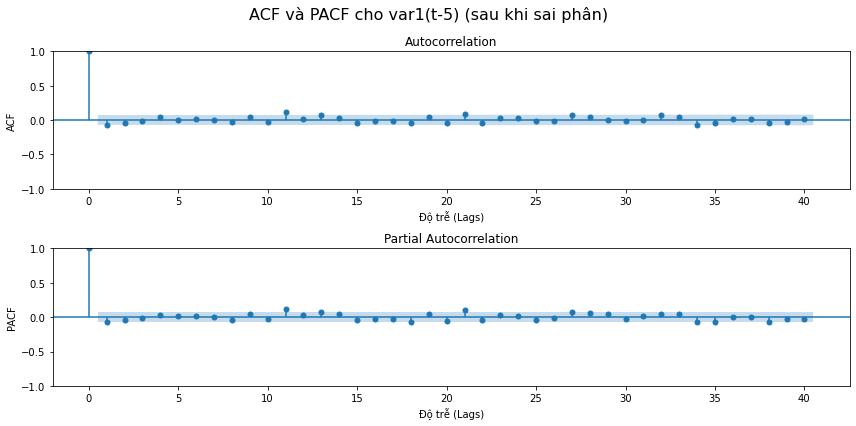

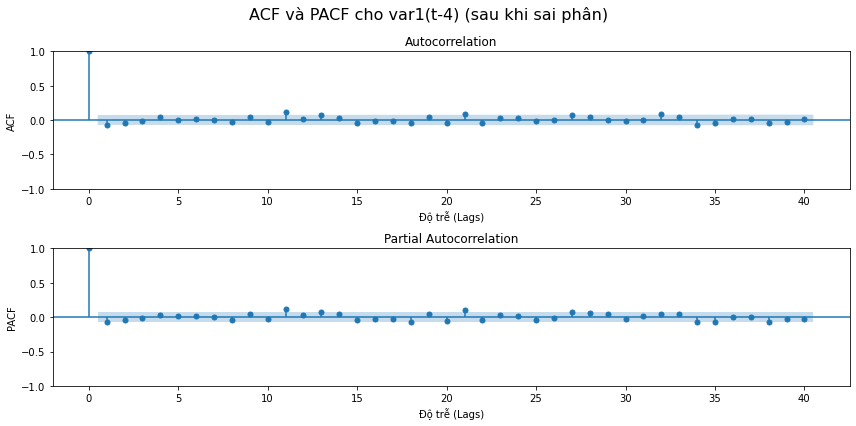

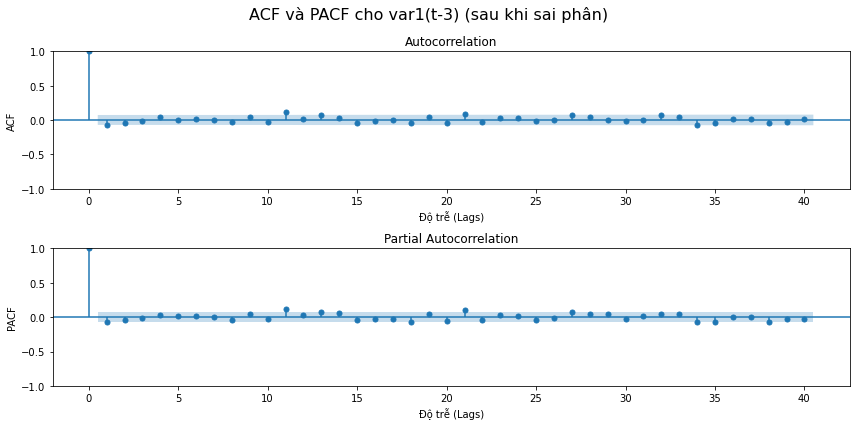

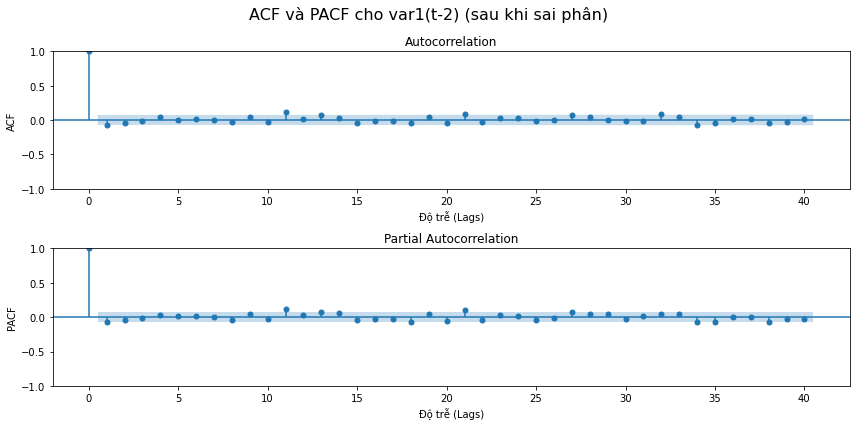

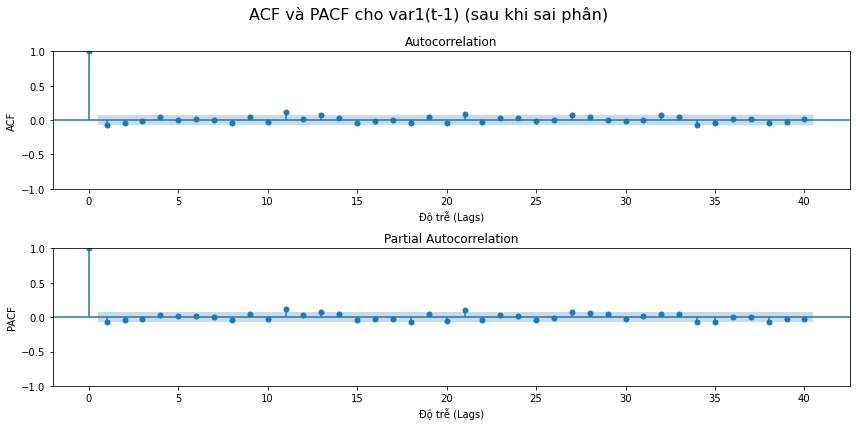

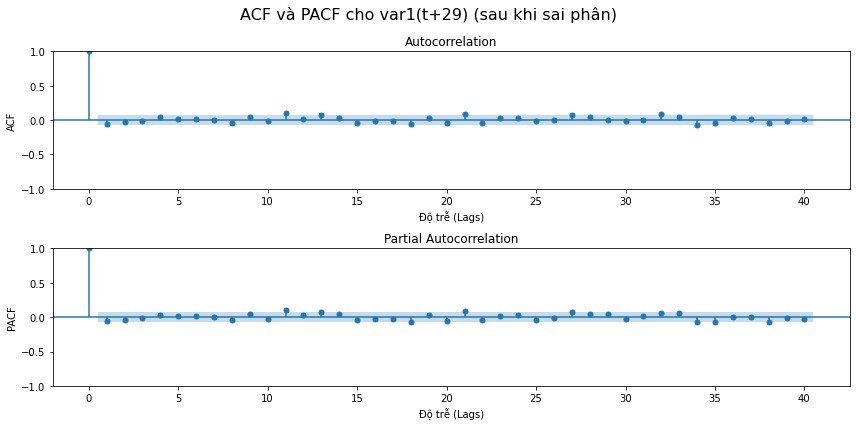

In [23]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Vẽ ACF và PACF cho mỗi cột trong reframed_diff
for col in reframed_diff.columns:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'ACF và PACF cho {col} (sau khi sai phân)', fontsize=16)
    
    # Vẽ ACF
    plt.subplot(2, 1, 1)
    plot_acf(reframed_diff[col].dropna(), lags=40, ax=plt.gca())
    plt.xlabel('Độ trễ (Lags)')
    plt.ylabel('ACF')
    
    # Vẽ PACF
    plt.subplot(2, 1, 2)
    plot_pacf(reframed_diff[col].dropna(), lags=40, ax=plt.gca())
    plt.xlabel('Độ trễ (Lags)')
    plt.ylabel('PACF')
    
    plt.tight_layout()
    plt.show()

<u>Nhận xét:</u> Trục hoành là độ trễ, trục tung là giá trị của hệ số tự tương quan tương ứng với độ trễ. Dải màu xanh chính là khoảng tin cậy 95% để giá trị hệ số tự tương quan bằng 0.<br>
<br><u> Đối với mô hình ARIMA (p, d, q):

+ p (bậc của AR): Xem đỉnh trên đồ thị PACF. Nếu có một đỉnh đột biến sau một số lượng lag cụ thể và giảm xuống 0 sau đó, chọn p là số lag đó. -> p = 1
+ d (bậc của sai phân): Xem xem có cần sai phân để làm cho chuỗi dừng. Nếu cần, chọn d là số lần sai phân cần thiết -> d = 1
+ q (bậc của MA): Xem đỉnh trên đồ thị ACF. Nếu có một đỉnh đột biến sau một số lượng lag cụ thể và giảm xuống 0 sau đó, chọn q là số lag đó -> q = 1

####  &ensp; 1.a.2 Phương pháp auto_arima 

In [24]:
from pmdarima import auto_arima
model = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=7,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# print(model.aic())

# Fit auto_arima
#model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True, suppress_warnings=True)

# Print the model summary
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8719.942, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8718.375, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8718.500, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8720.281, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8720.314, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8722.233, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8717.417, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8719.412, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8719.383, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8719.407, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8717.544, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8721.391, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.657 seconds
                               SARIMAX Results                                
Dep. Vari

### &nbsp; 1.b Hoàn thành mô hình và dự đoán

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Replace with our best params
p, d, q = 1, 0, 0

# Create and fit the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Print model summary
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             var1(t+29)   No. Observations:                  591
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4355.708
Date:                Thu, 21 Sep 2023   AIC                           8717.417
Time:                        06:44:38   BIC                           8730.562
Sample:                             0   HQIC                          8722.538
                                - 591                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2492     15.672      1.611      0.107      -5.468      55.966
ar.L1         -0.0821      0.039     -2.105      0.035      -0.158      -0.006
sigma2      1.478e+05   3815.862     38.743      0.0

## 2. Xây dựng model SARIMA 
### &nbsp; 2.a Lựa chọn tham số SARIMA(p, d, q)(P, D, Q)
####  &ensp; 2.a.1. ACF và PACF

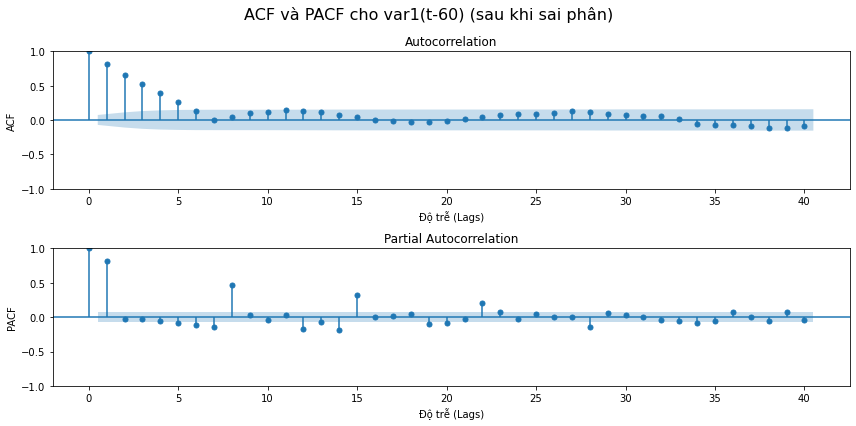

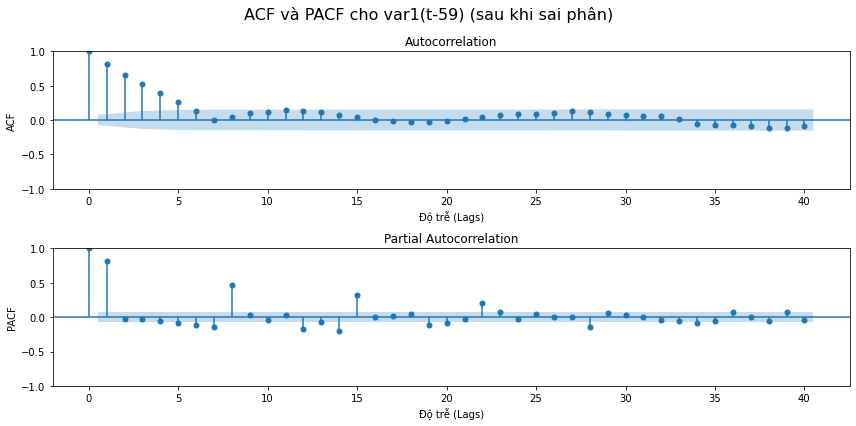

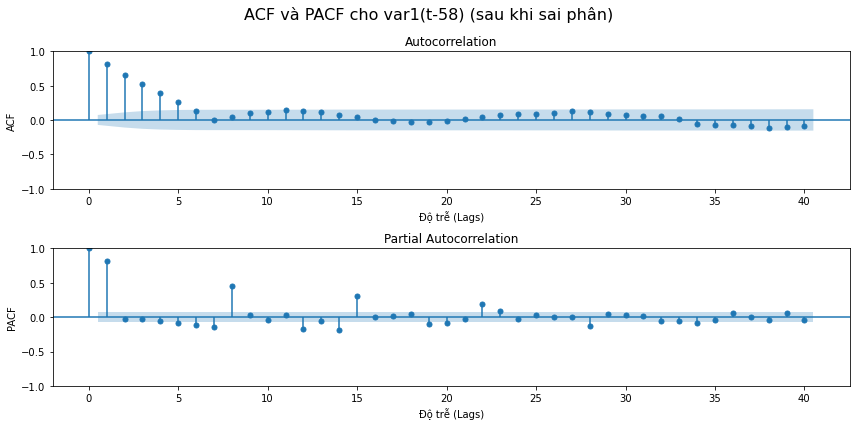

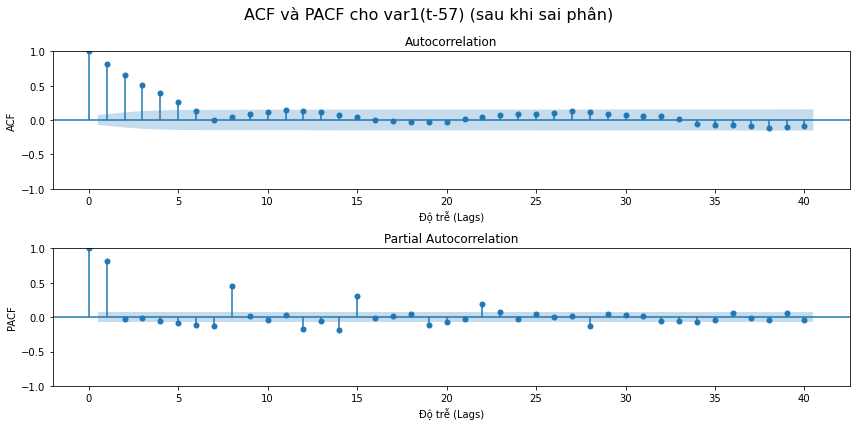

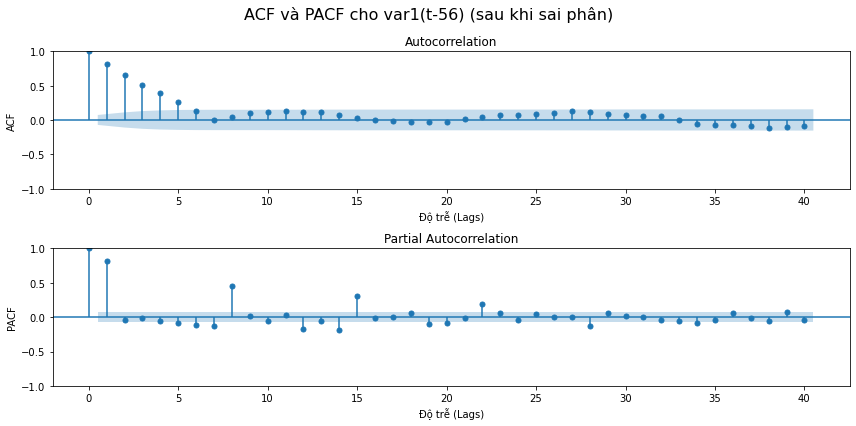

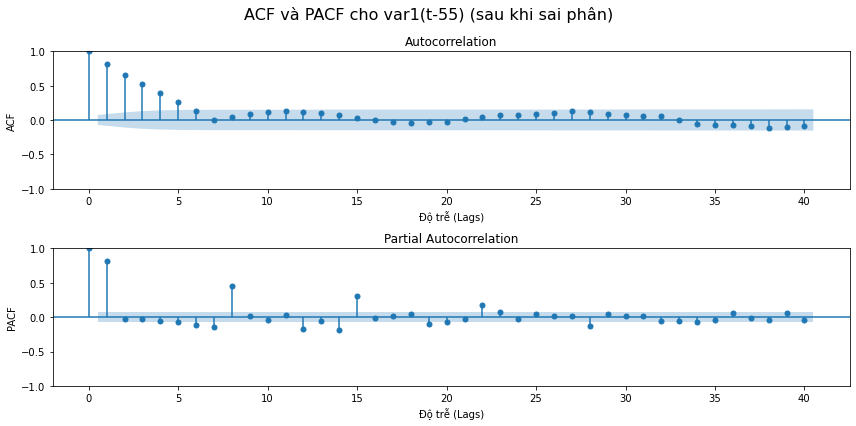

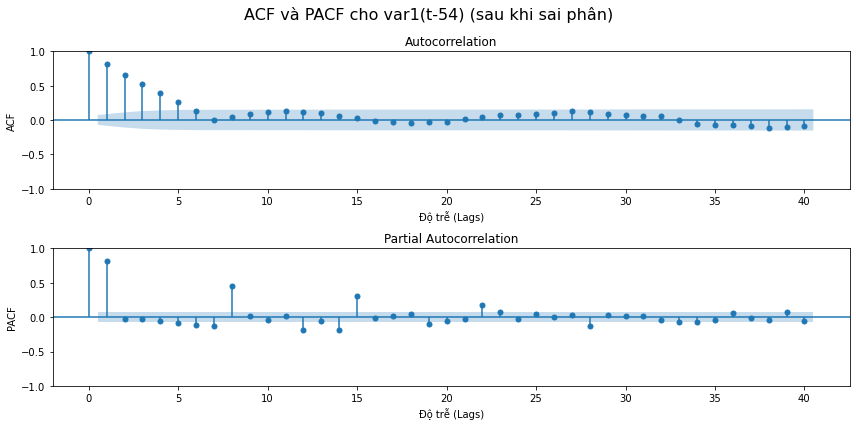

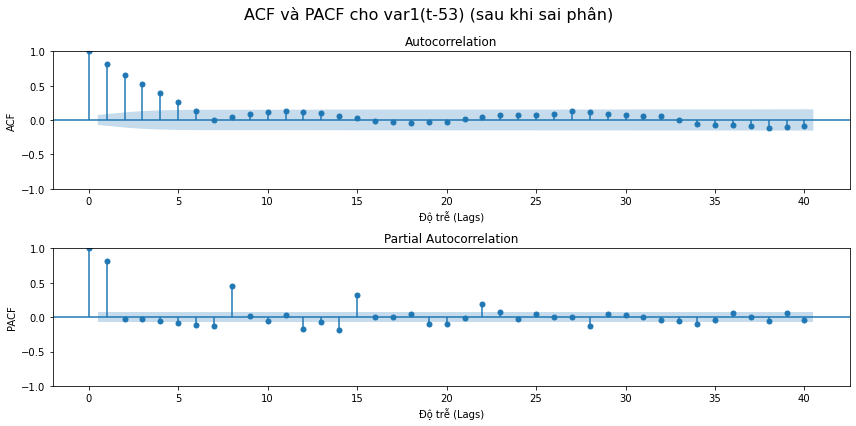

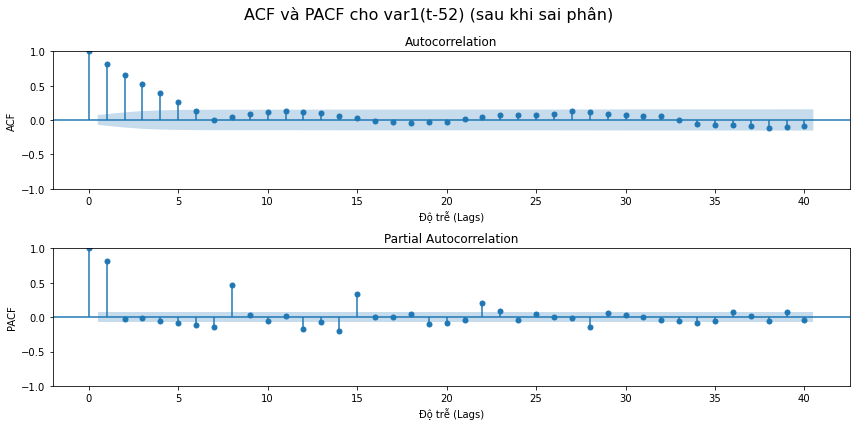

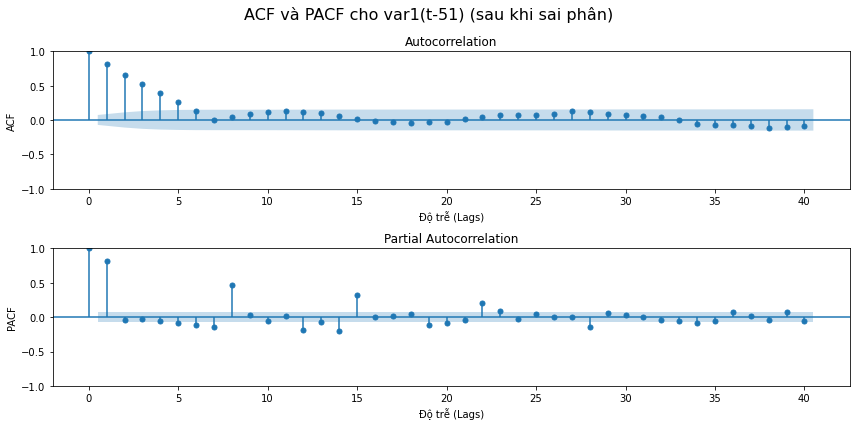

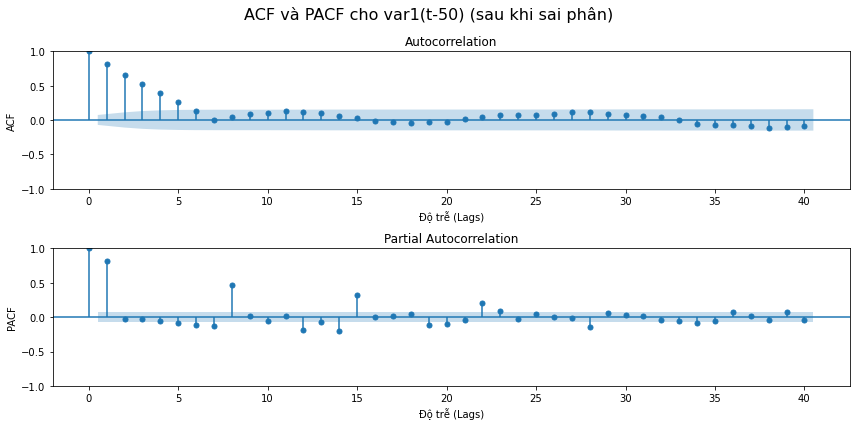

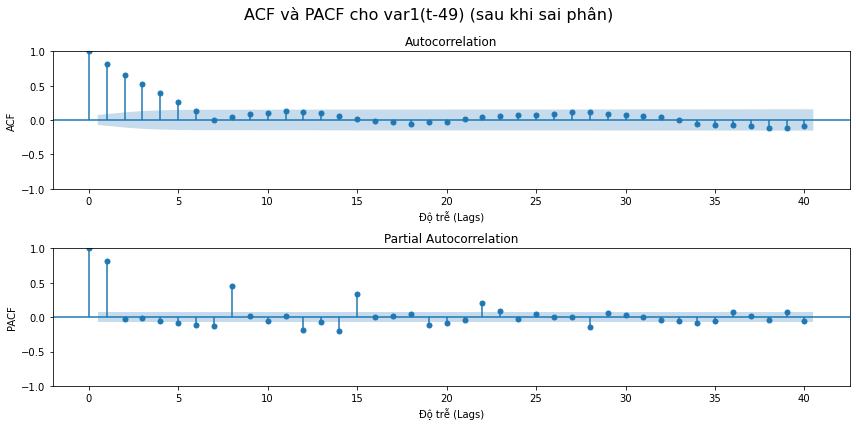

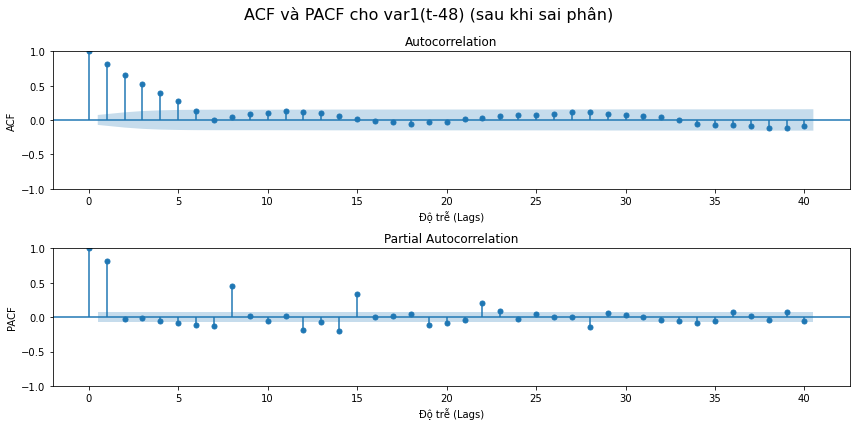

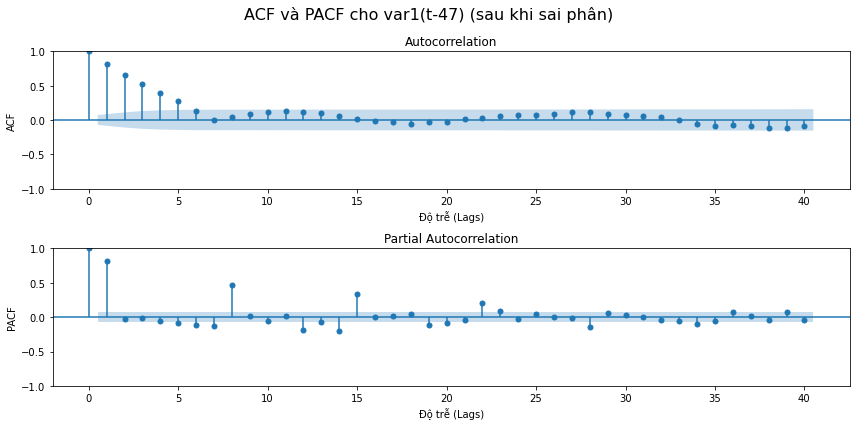

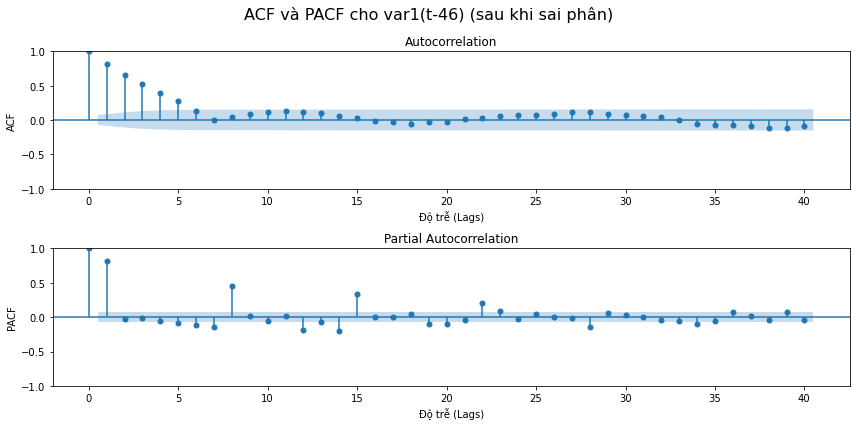

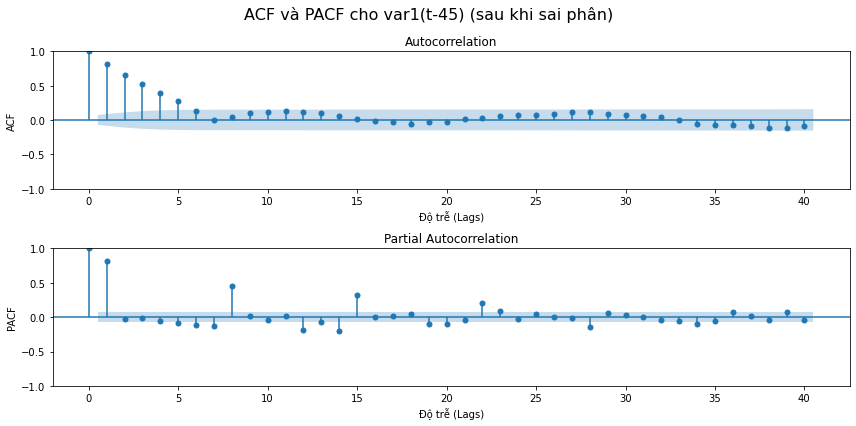

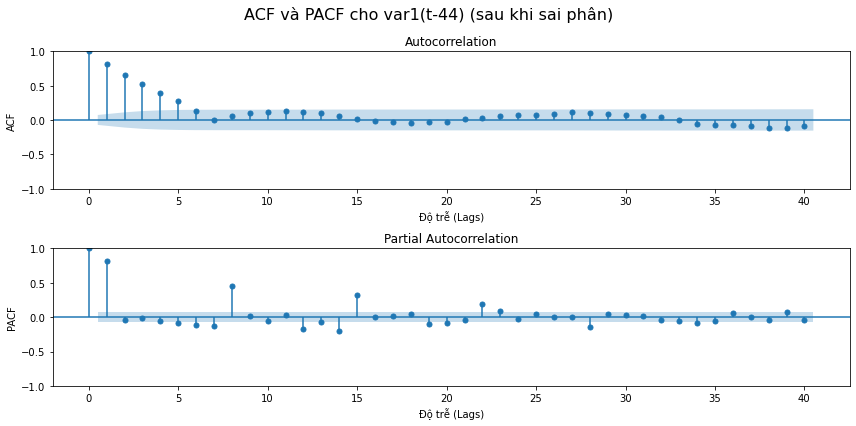

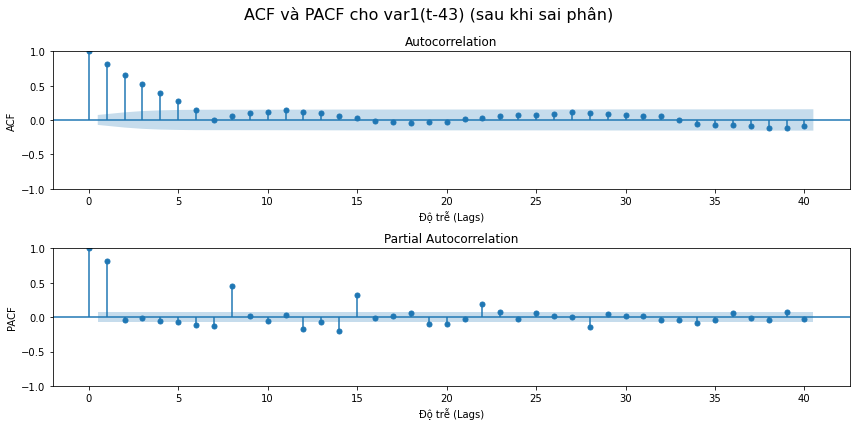

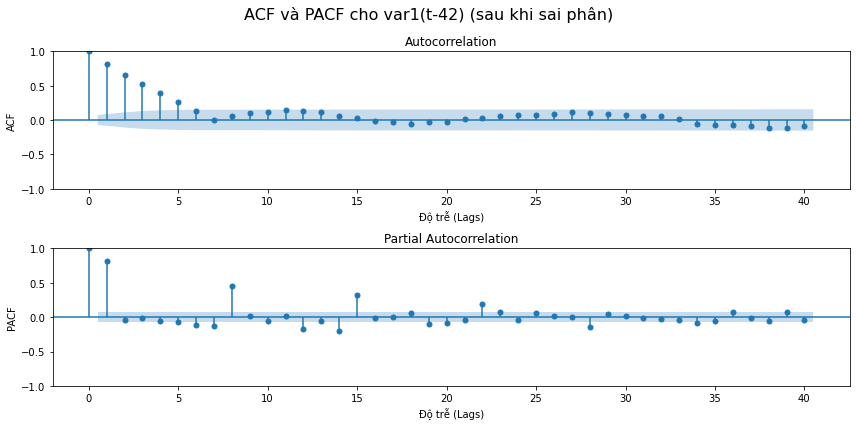

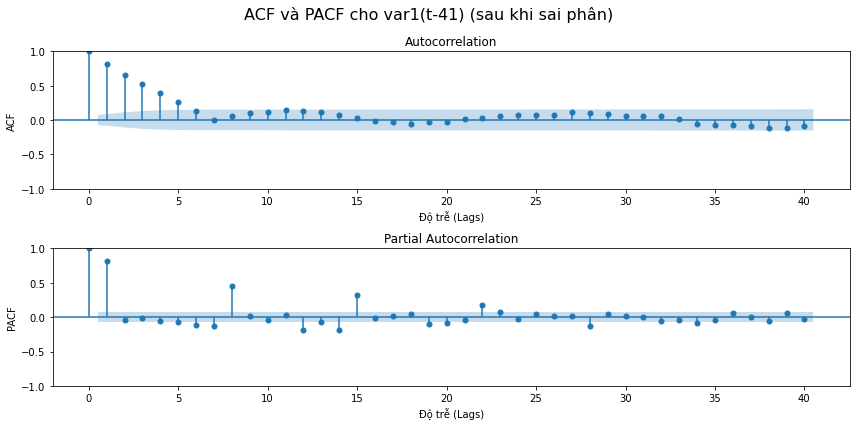

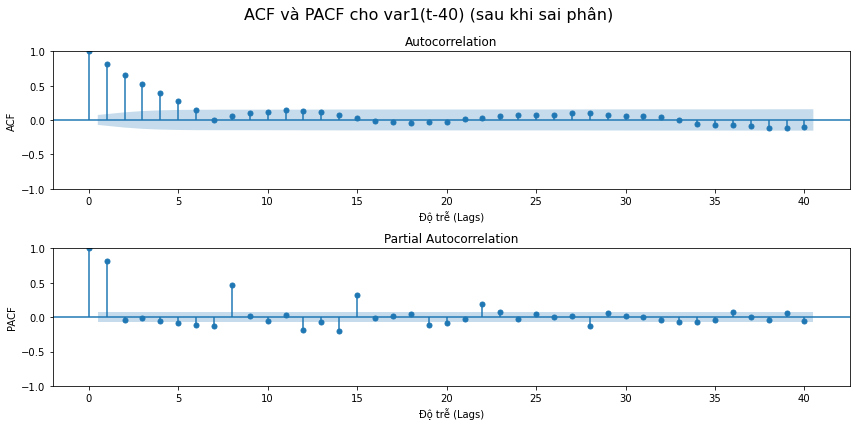

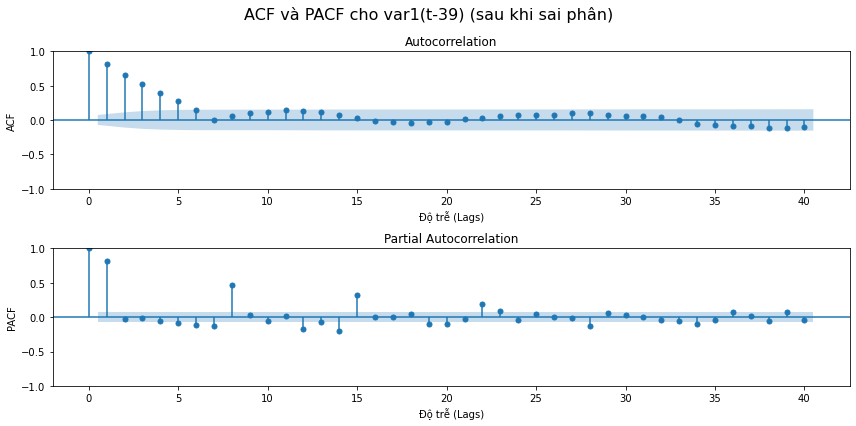

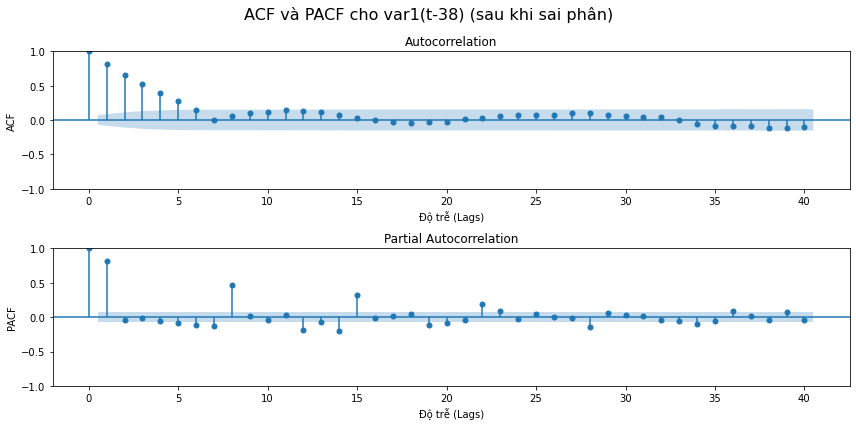

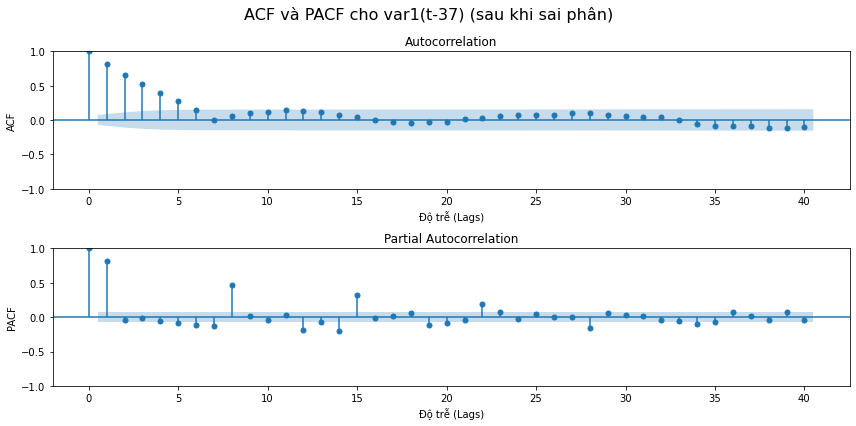

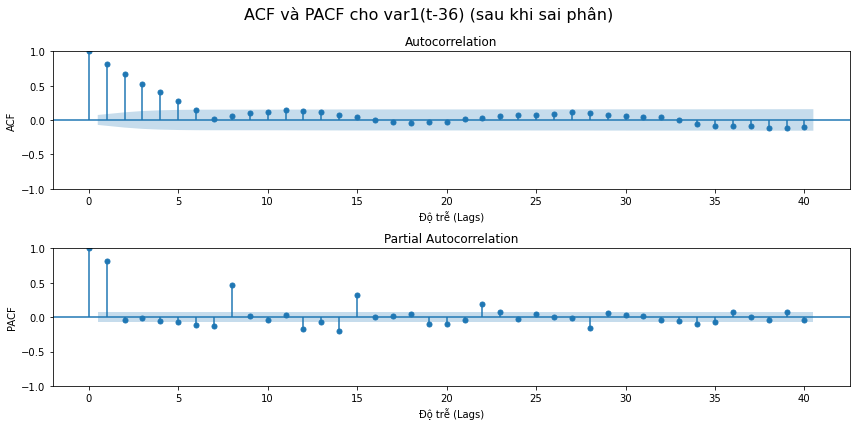

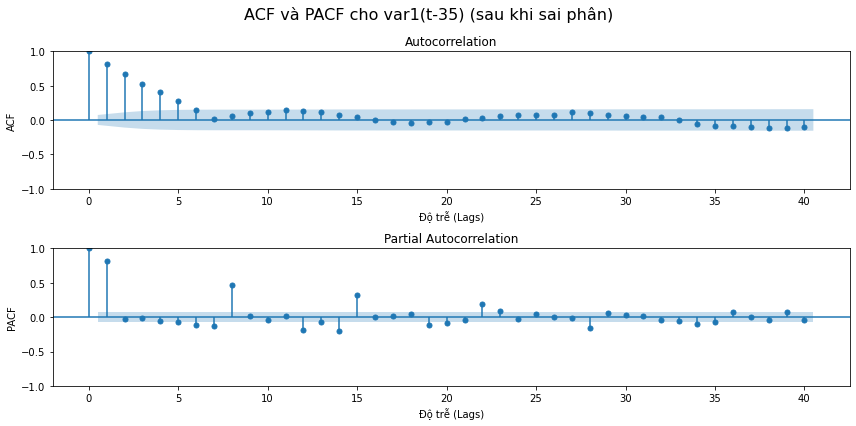

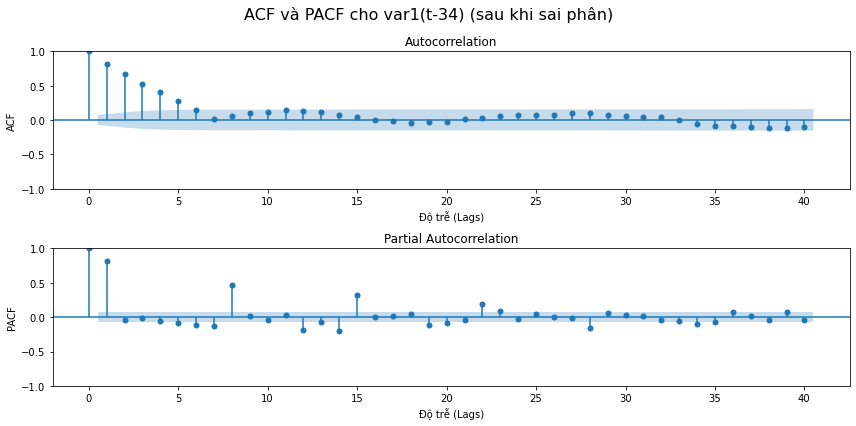

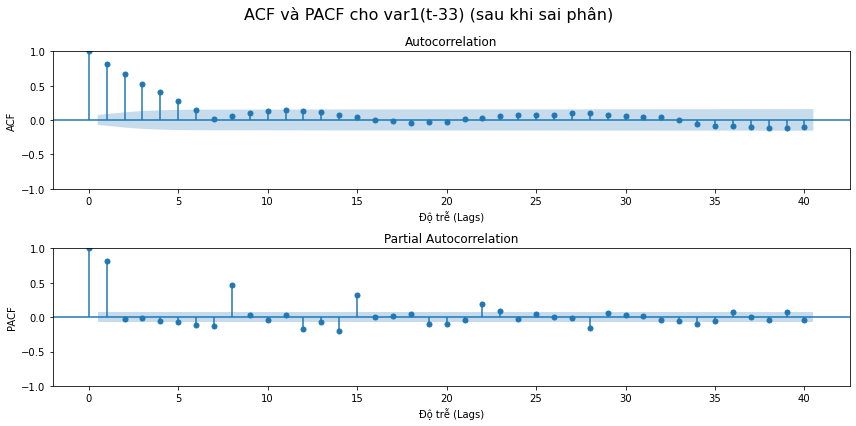

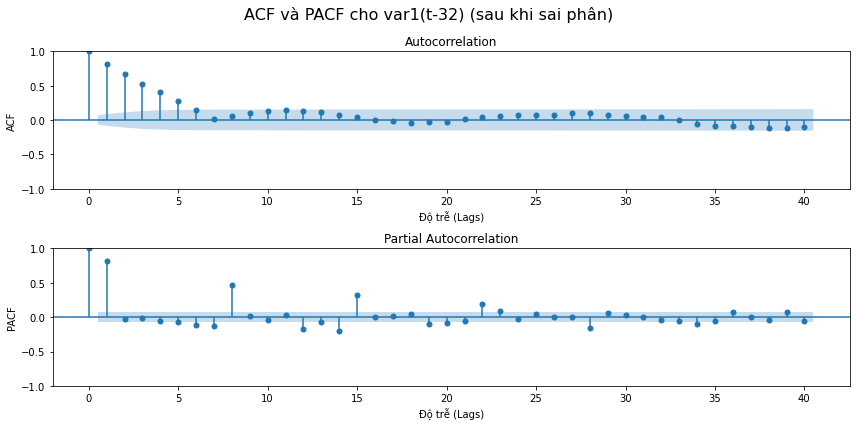

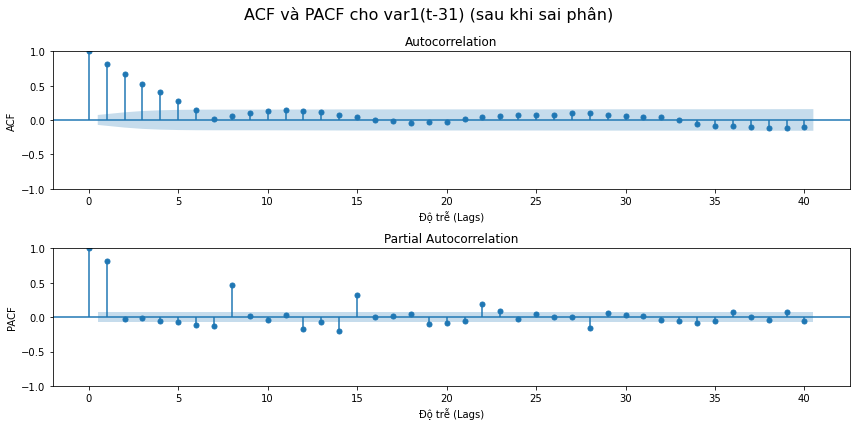

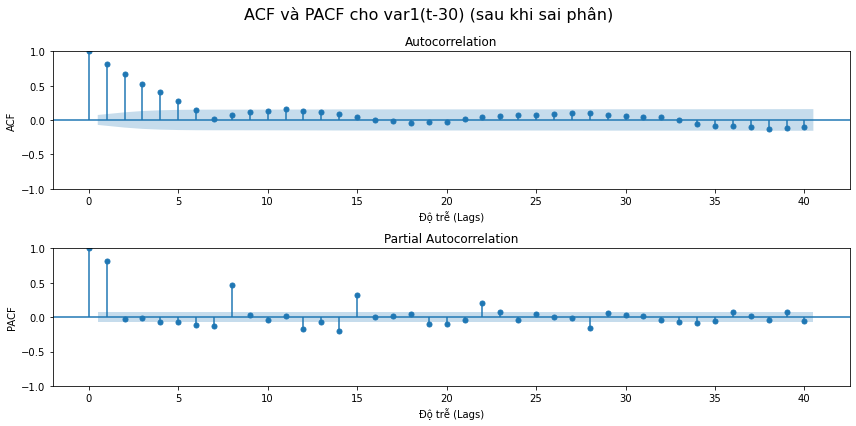

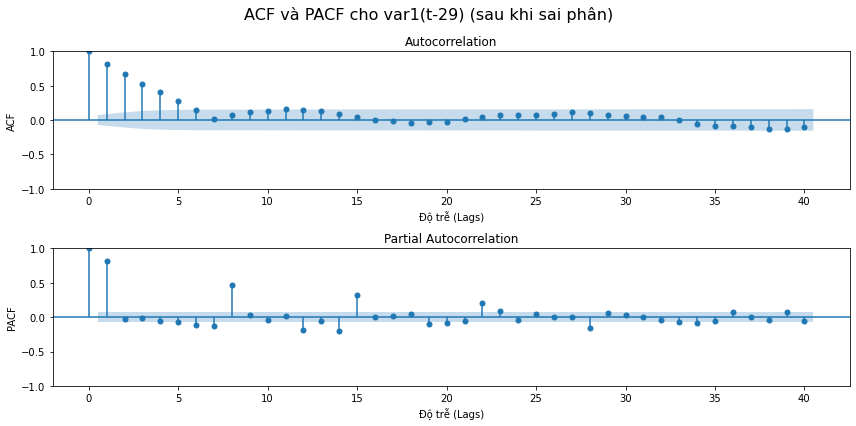

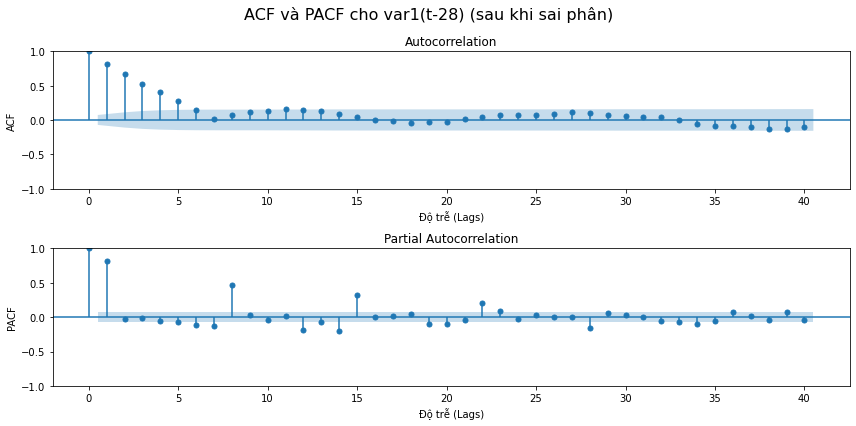

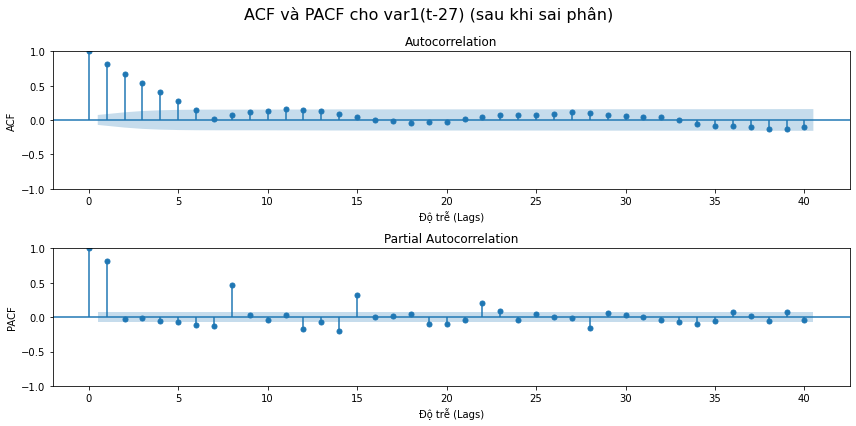

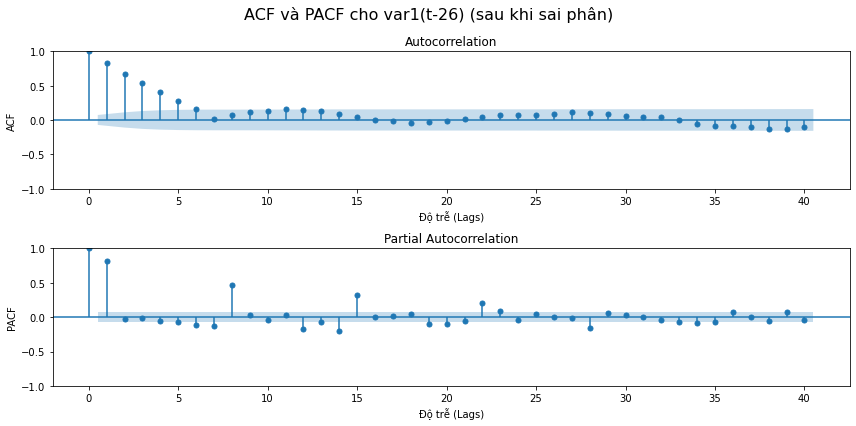

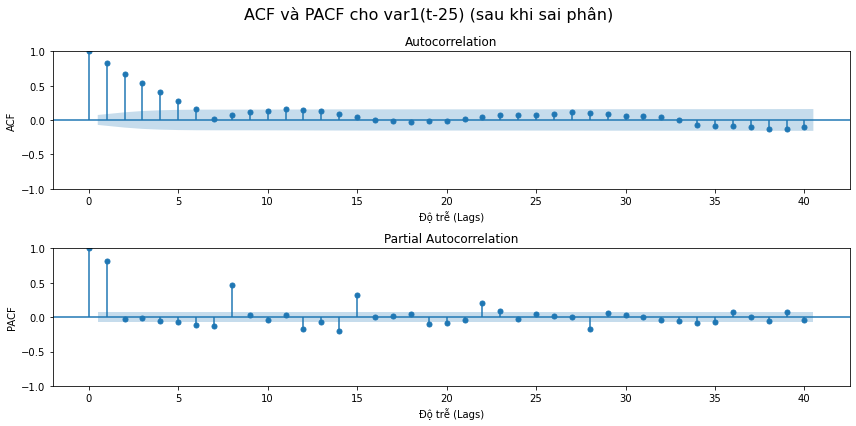

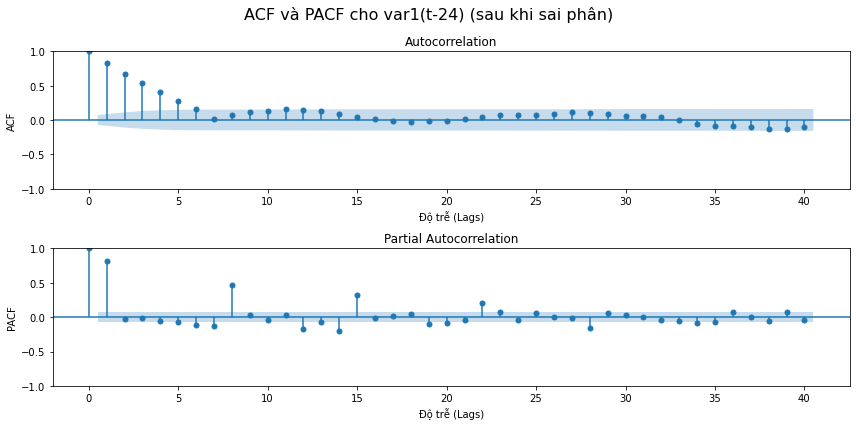

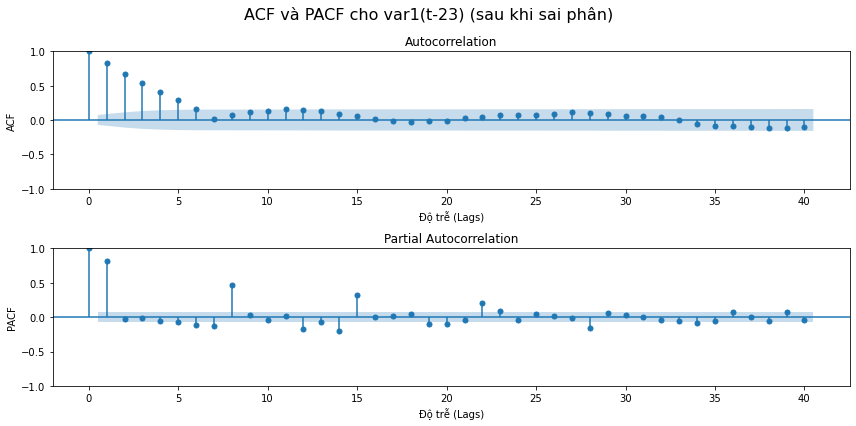

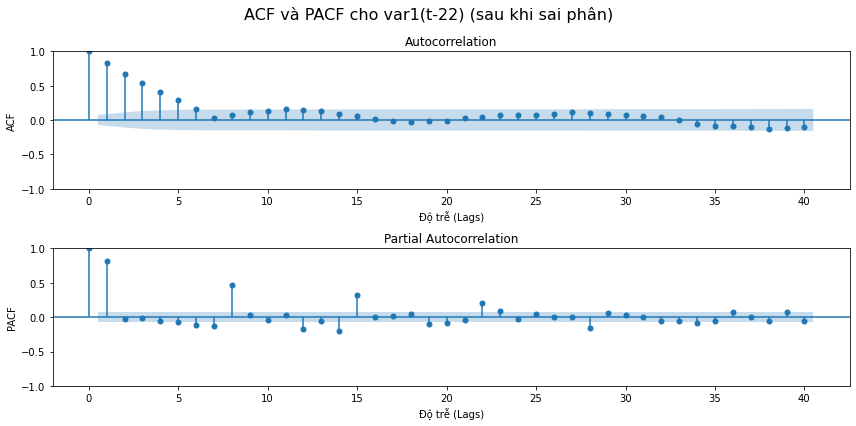

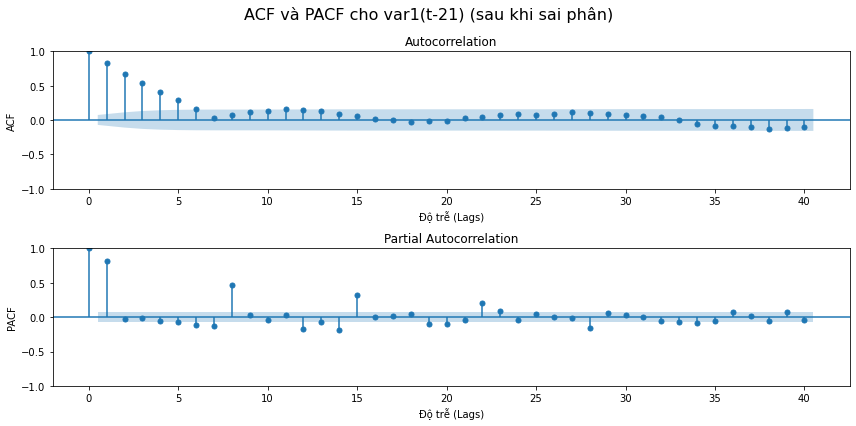

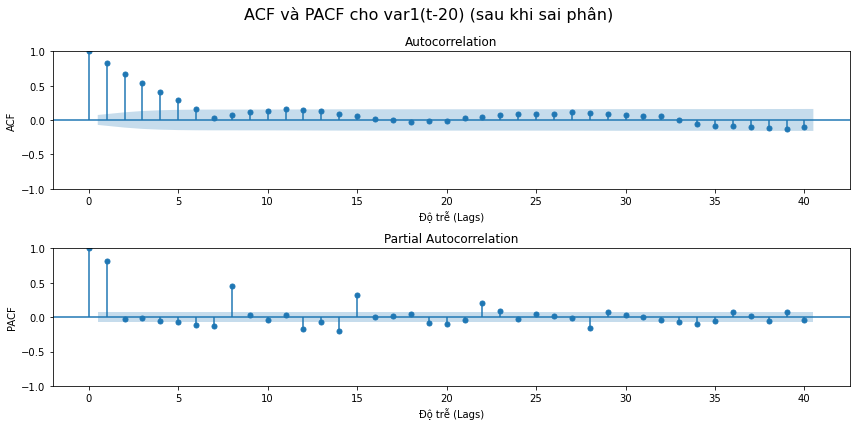

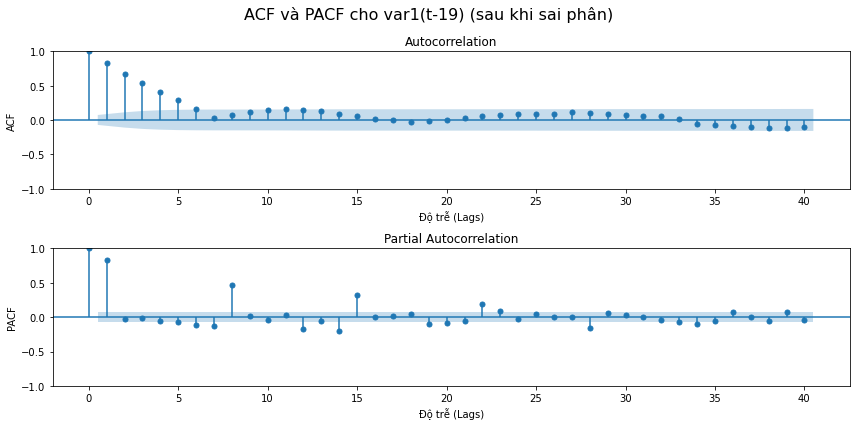

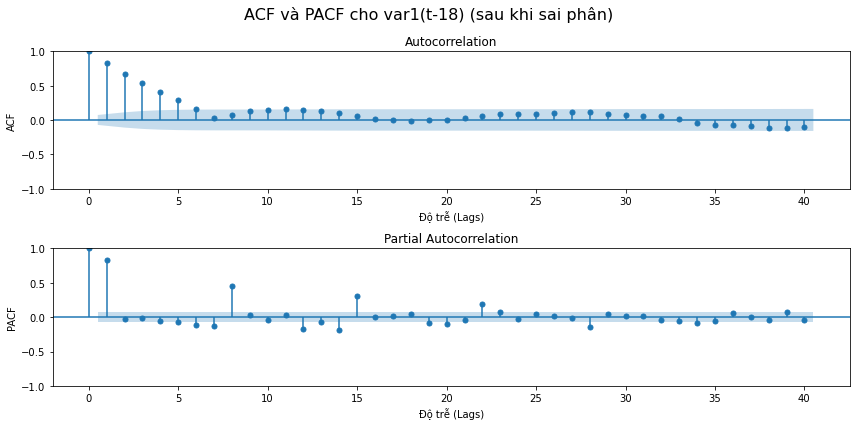

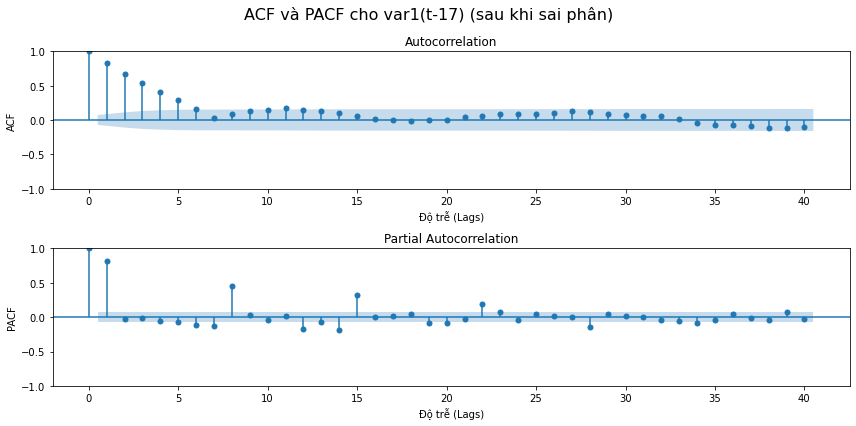

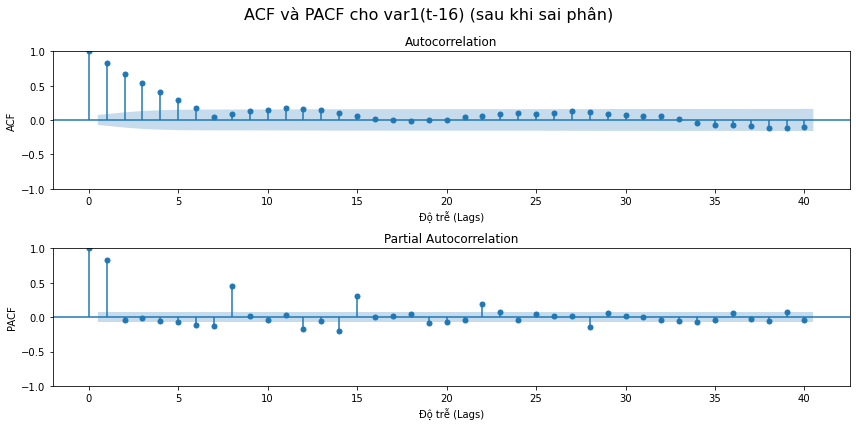

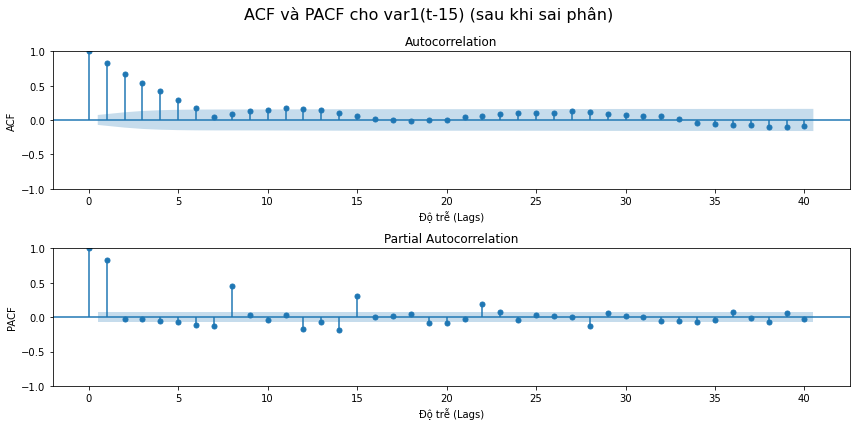

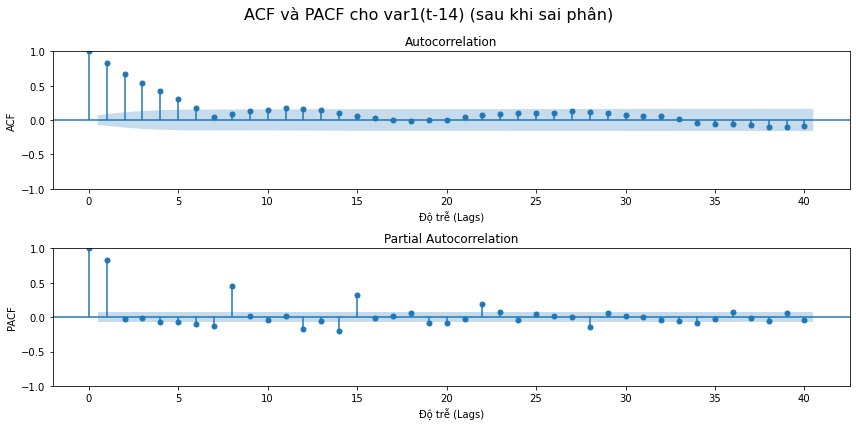

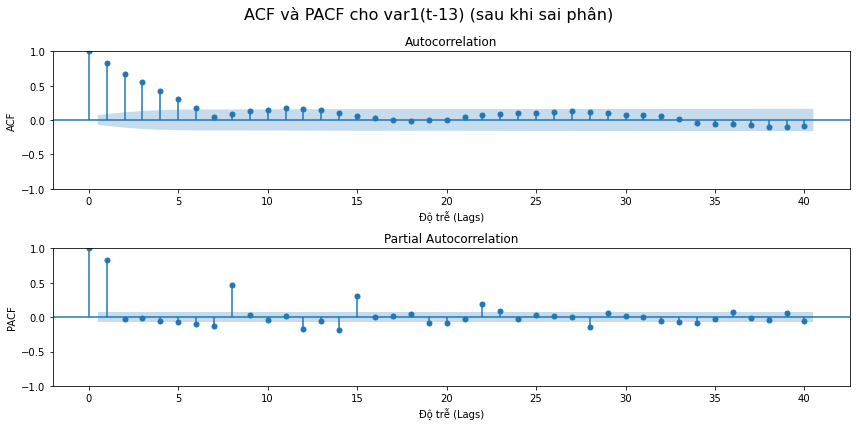

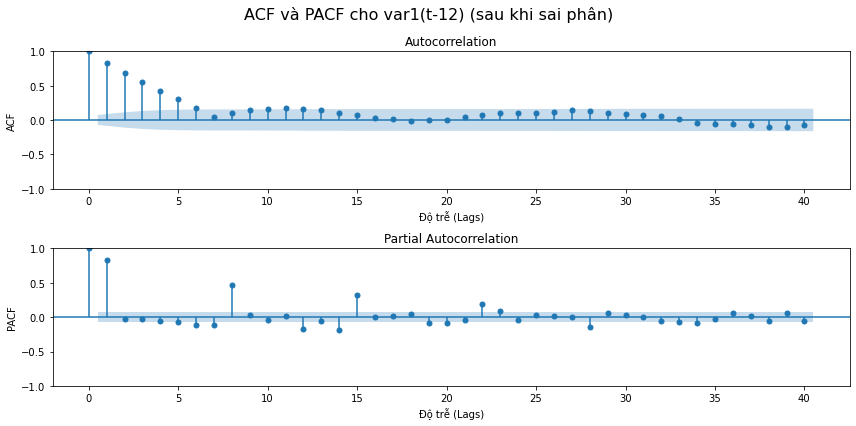

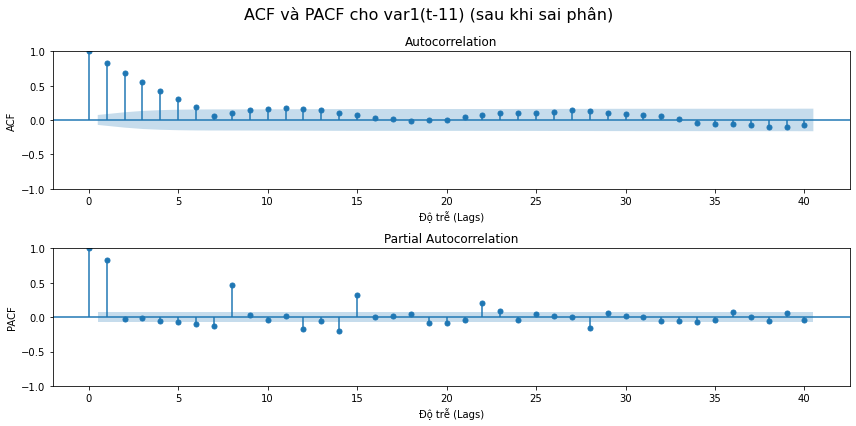

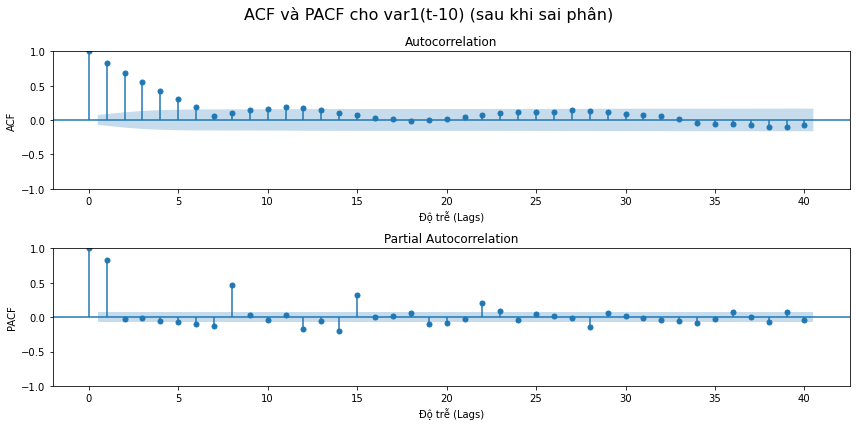

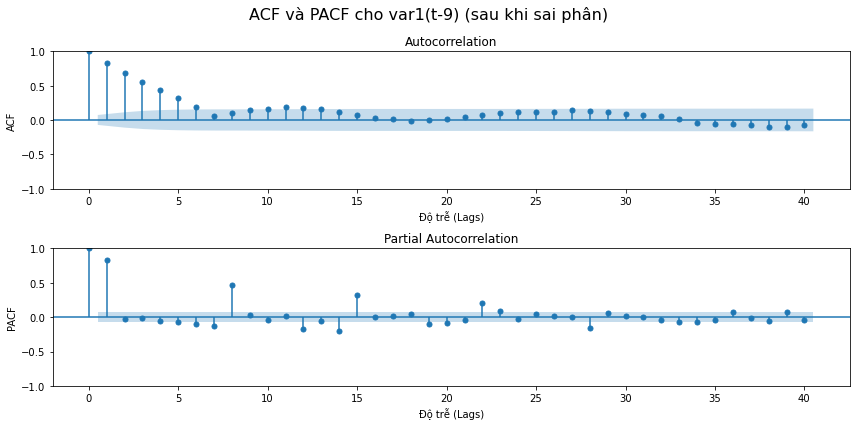

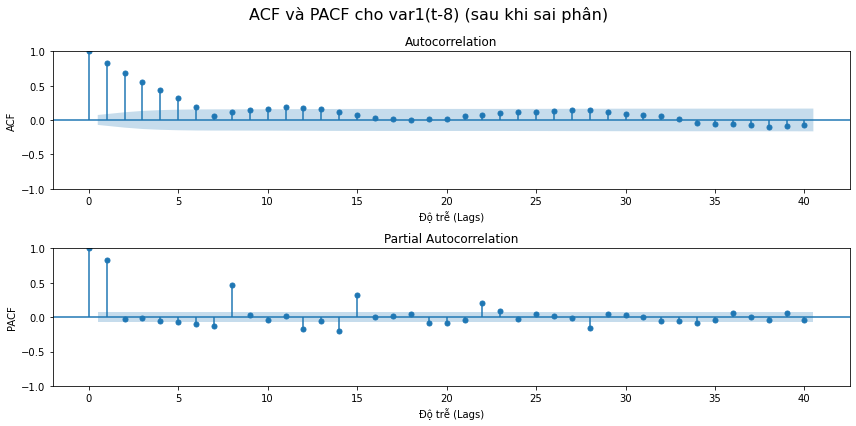

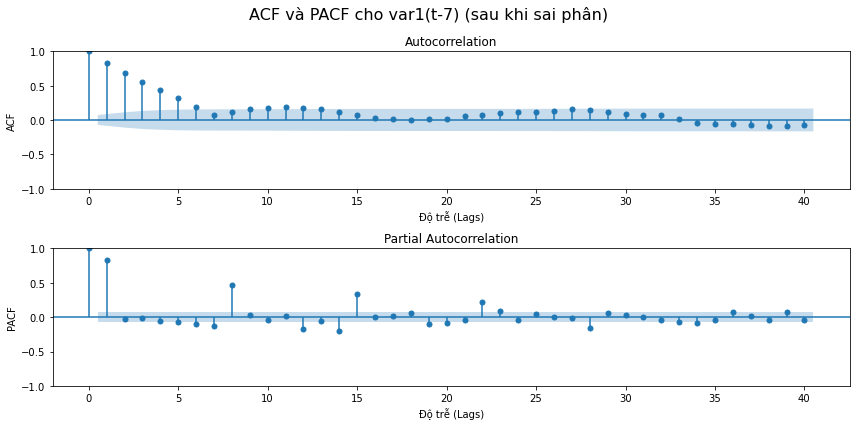

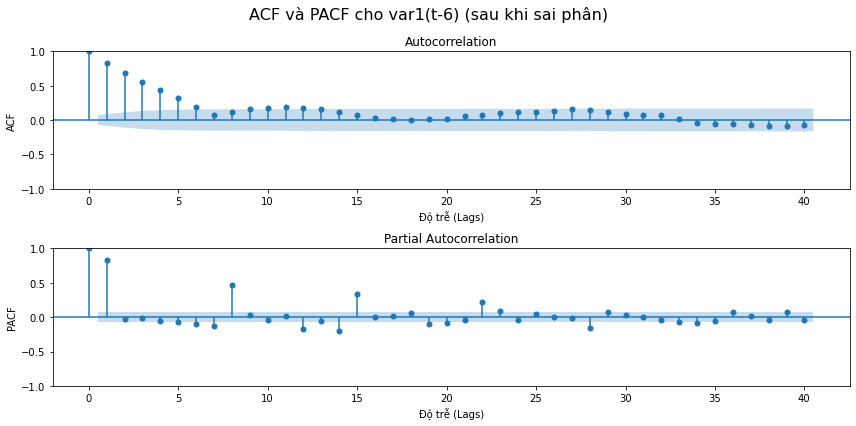

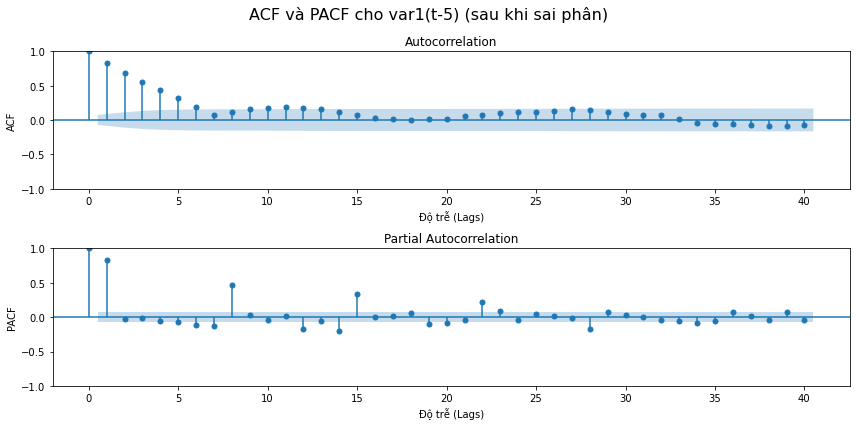

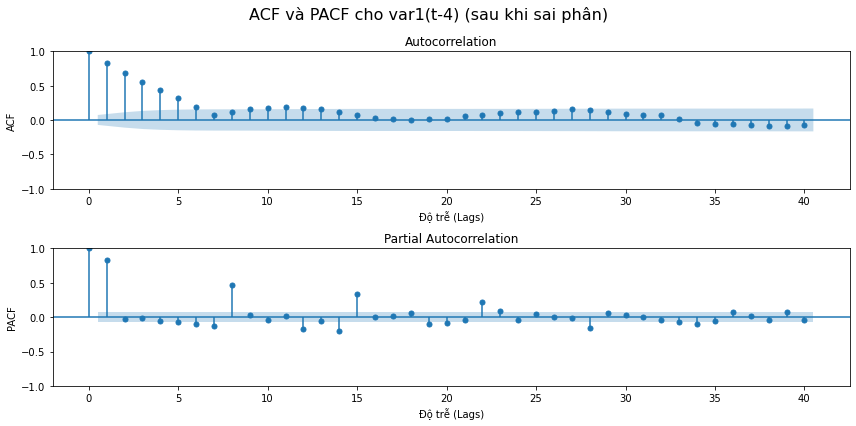

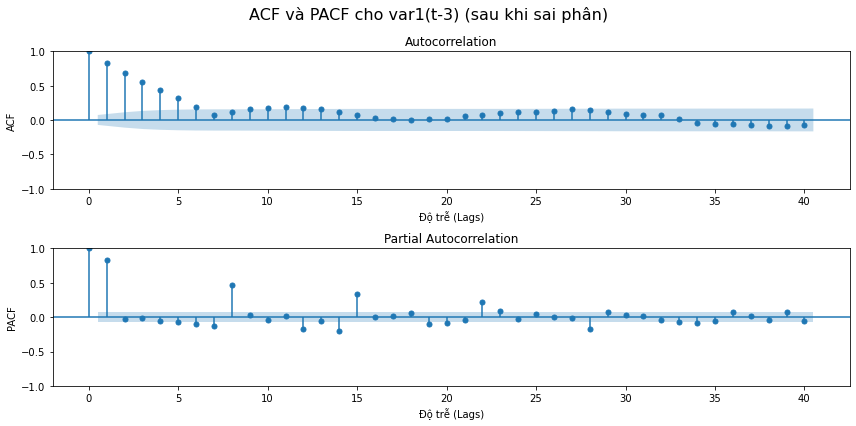

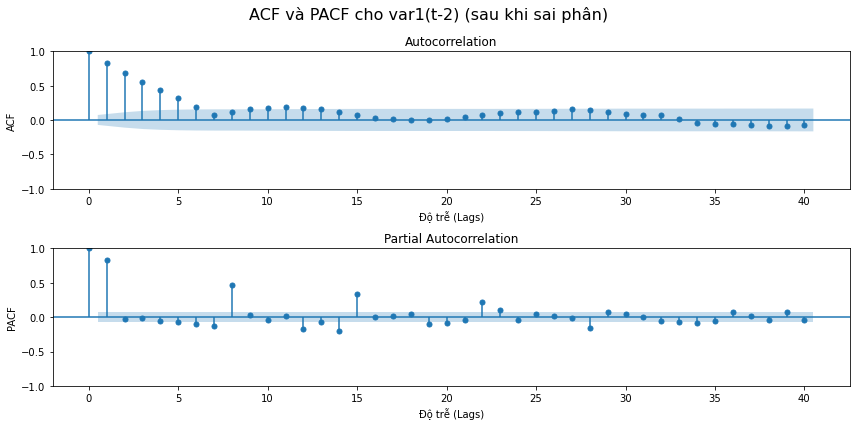

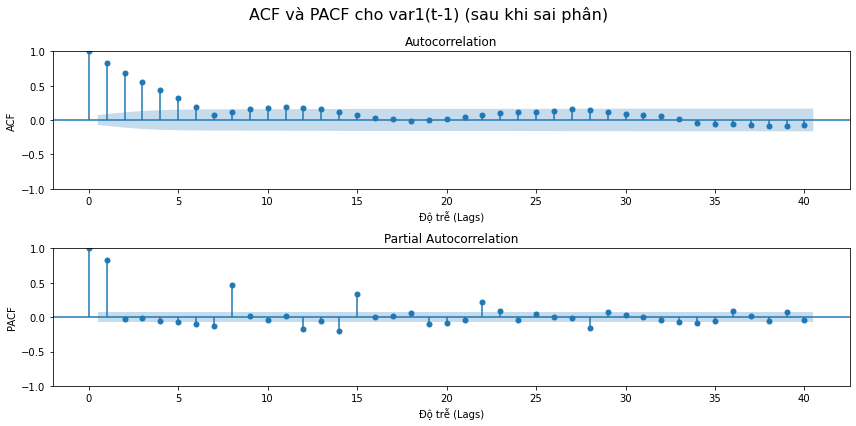

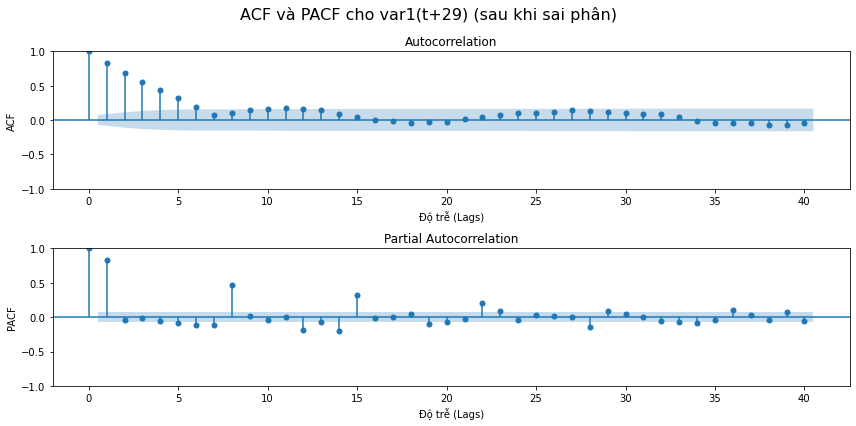

In [41]:
# Vẽ ACF và PACF cho mỗi cột trong reframed_seasonal_diff
for col in reframed_seasonal_diff.columns:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'ACF và PACF cho {col} (sau khi sai phân)', fontsize=16)
    
    # Vẽ ACF
    plt.subplot(2, 1, 1)
    plot_acf(reframed_seasonal_diff[col].dropna(), lags=40, ax=plt.gca())
    plt.xlabel('Độ trễ (Lags)')
    plt.ylabel('ACF')
    
    # Vẽ PACF
    plt.subplot(2, 1, 2)
    plot_pacf(reframed_seasonal_diff[col].dropna(), lags=40, ax=plt.gca())
    plt.xlabel('Độ trễ (Lags)')
    plt.ylabel('PACF')
    
    plt.tight_layout()
    plt.show()

####  &ensp; 2.a.2 Phương pháp auto_arima 

In [67]:
# Fit auto_arima with stepwise mode and trace the process
model = auto_arima(y_seasonal_train,start_p=0, start_q=0,
                                    max_p=5, max_q=5, m=7,
                                    start_P=0, seasonal=True,
                                    d=1, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)

# Print the model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9462.220, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=9076.674, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9269.128, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=9014.669, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=9225.971, Time=0.06 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8932.703, Time=0.36 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=9001.873, Time=0.24 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.79 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=8895.199, Time=0.51 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8960.553, Time=0.29 s

### &nbsp; 2.b Hoàn thành mô hình và dự đoán

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Replace with our best params
order = p, d, q = 5, 1, 0
seasonal_order = P, D, Q, s = 2, 1, 0, 7

# Create and fit the SARIMA model
sarima_model = SARIMAX(y_seasonal_train, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()


# model summary
print(sarima_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        var1(t+29)   No. Observations:                  591
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -4422.658
Date:                           Thu, 21 Sep 2023   AIC                           8861.316
Time:                                   07:11:45   BIC                           8896.261
Sample:                                        0   HQIC                          8874.937
                                           - 591                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9333      0.045    -20.780      0.000      -1.021      -0.845
ar.L2         -0.7389      0.063    -11.689

## 3. Dự đoán

### 3.1. For ARIMA

In [29]:
# Get the predictions on the test set
y_pred = arima_model_fit.forecast(steps=len(X_test))

# Print the first few predictions
print("Predictions:\n", y_pred)

Predictions:
 591     2.701226
592    27.099689
593    25.097377
594    25.261701
595    25.248215
         ...    
734    25.249238
735    25.249238
736    25.249238
737    25.249238
738    25.249238
Name: predicted_mean, Length: 148, dtype: float64


#### Invert value và compare

In [30]:
#invrt func
def invert_diff(diff_series, first_value):
     return np.r_[first_value, diff_series].cumsum().astype(float)

In [31]:
y_pred = invert_diff(y_pred, first_value=y_train.iloc[look_back])
y_test_transformed = invert_diff(y_test, first_value=y_train.iloc[look_back])

#### Plot the original vs. predicted prices

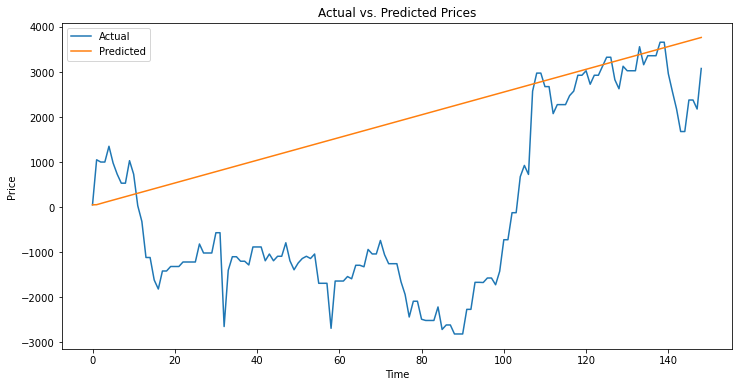

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_transformed, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('RMSE: %.2f (đồng)' % (testScore))
    
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('\nMAE: %.2f (đồng)' % (testScore))
                            
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('\nMAPE: %.2f' % (testScore))
    
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('\nMASE: %.2f' % (testScore))

In [34]:
# print results
print_metrics(y_test_transformed, y_pred)

RMSE: 2515.15 (đồng)

MAE: 2046.93 (đồng)

MAPE: 1.76

MASE: 8.23


### 3.2 For SARIMA (invert sai )

In [69]:
# Forecast on the test set
y_seasonal_pred = sarima_model_fit.forecast(steps=len(X_seasonal_test))

# Print the first few predictions
print("Predictions:\n", y_seasonal_pred)

Predictions:
 591    186.087514
592     91.727620
593   -410.034696
594    195.761853
595    248.242047
          ...    
734     23.866169
735   -130.010034
736   -305.939329
737    -55.349421
738    -49.364517
Name: predicted_mean, Length: 148, dtype: float64


In [70]:
#invrt func
def invert_diff(diff_series, first_value):
     return np.r_[first_value, diff_series].cumsum().astype(float)

In [71]:
y_seasonal_pred = invert_diff(y_seasonal_pred, first_value=y_train.iloc[look_back])
y_seasonal_test_transformed = invert_diff(y_seasonal_test, first_value=y_train.iloc[look_back])

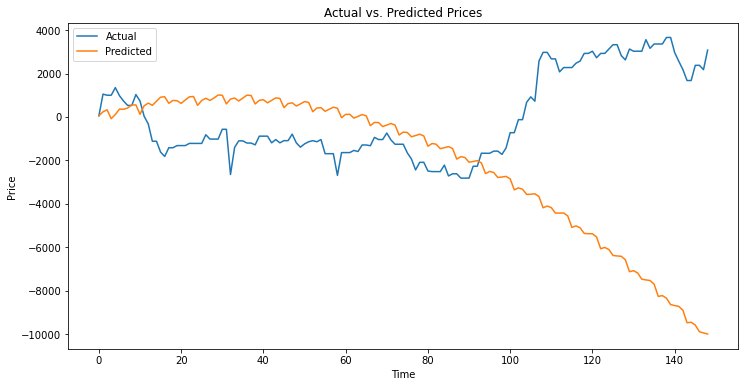

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(y_seasonal_test_transformed, label='Actual')
plt.plot(y_seasonal_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

In [73]:
# print results
print_metrics(y_seasonal_test_transformed, y_seasonal_pred)

RMSE: 5397.36 (đồng)

MAE: 3794.46 (đồng)

MAPE: 2.32

MASE: 15.26


In [ ]:
#COde from LSTM

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# Invert scaling for forecast
test_pred = test_pred.reshape(-1, 1)
inv_test_pred = np.concatenate((test_pred, test_X), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:, 0]